<a href="https://colab.research.google.com/github/baskayj/Boundary-behaviour-in-stochastic-differential-equations-used-in-Finance/blob/master/CIR_Boundary_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Boundary behaviour in stochastic differential equations used in Finance

In [0]:
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import multiprocessing as mp

from collections import namedtuple
from datetime import datetime

from scipy.stats import ks_2samp

In [0]:
font = {'size'   : 18}
plt.rc('font', **font)

In [0]:
#CIR MODEL
#There are multiple finite-diffrence schemes for simulation including,
#Euler-Maryama Scheme: X[i] = X[i-1] + kappa*(theta-X[i-1])*dt + sigma*np.sqrt(X[i-1])*W[i-1]*np.sqrt(dt)
#Weighted Milstein Scheme: X[i] = (X[i-1] + kappa*(theta-alpha*X[i-1])*dt + sigma*np.sqrt(X[i-1])*W[i-1]*np.sqrt(dt) + (1/4)*np.power(sigma,2)*dt*(np.power(W[i-1],2)-1))/(1+(1-alpha)*kappa*dt)
#Non-central chi^2 method which means taking values for the expected distribution.

#gamma = 2*kappa*theta/sigma^2

#-------------------------------------------------------------------------------
def CIR_prcss(X0, dt, T, kappa, theta, sigma, seed, **kwargs):
  if kwargs.get('WMS'):
  #Weighted Milstein Scheme

    if kwargs.get('Path'):
    #Returns the entire trajectory
      N = int(T/dt)
      alpha = 0.8
      np.random.seed(seed)
      W = np.random.normal(size=N)
      X = np.zeros(N)
      X[0] = X0
      for i in range(1,N):
        x = (X[i-1] + kappa*(theta-alpha*X[i-1])*dt + sigma*np.sqrt(X[i-1])*W[i-1]*np.sqrt(dt) + (1/4)*np.power(sigma,2)*dt*(np.power(W[i-1],2)-1))/(1+(1-alpha)*kappa*dt)
        if x < 0 :
          X[i] = 0
        else:
          X[i] = x
      return X

    elif kwargs.get('Barrier'):
    #Returns wich barrier was hit first by the trajectory. (0 or 2*X0 or neither)
      N = int(T/dt)
      alpha = 0.8
      np.random.seed(seed)
      W = np.random.normal(size=N)
      X = np.zeros(N)
      X[0] = X0
      for i in range(1,N):
        x = (X[i-1] + kappa*(theta-alpha*X[i-1])*dt + sigma*np.sqrt(X[i-1])*W[i-1]*np.sqrt(dt) + (1/4)*np.power(sigma,2)*dt*(np.power(W[i-1],2)-1))/(1+(1-alpha)*kappa*dt)
        if x < 0 :
          return -1
        elif x > (2*X0):
          return 1    
        else:
          X[i] = x
      return 0

    else:
    #Returns Endpoint Only
      N = int(T/dt)
      alpha = 0.8
      np.random.seed(seed)
      W = np.random.normal(size=N)
      X = np.zeros(N)
      X[0] = X0
      for i in range(1,N):
        x = (X[i-1] + kappa*(theta-alpha*X[i-1])*dt + sigma*np.sqrt(X[i-1])*W[i-1]*np.sqrt(dt) + (1/4)*np.power(sigma,2)*dt*(np.power(W[i-1],2)-1))/(1+(1-alpha)*kappa*dt)
        if x < 0 :
          X[i] = 0
        else:
          X[i] = x
      return X[N-1]

#-------------------------------------------------------------------------------  
  elif kwargs.get('Exact'):
  #Exact Scheme (Non-central chi^2 method)
  
    if kwargs.get('Path'):
    #Returns the entire trajectory
      k = ((4*kappa*theta)/(np.power(sigma,2)))                                     # Degrees of Freedom
      eta = (4*kappa*np.exp(-kappa*dt))/(np.power(sigma,2)*(1-np.exp(-kappa*dt)))   # Helper function for the Non-centrality parameter

      N = int(T/dt)
      np.random.seed(seed)
      X = np.zeros(N)
      X[0] = X0
      for i in range(1,N):
        X[i] = np.random.noncentral_chisquare(k,X[i-1]*eta) * ((np.power(sigma,2)*(1-np.exp(-kappa*dt)))/(4*kappa))
      return X

    elif kwargs.get('Barrier'):
    #Returns wich barrier was hit first by the trajectory. (0 or 2*X0 or neither)
      k = ((4*kappa*theta)/(np.power(sigma,2)))                                     # Degrees of Freedom
      eta = (4*kappa*np.exp(-kappa*dt))/(np.power(sigma,2)*(1-np.exp(-kappa*dt)))   # Helper function for the Non-centrality parameter

      N = int(T/dt)
      np.random.seed(seed)
      X = np.zeros(N)
      X[0] = X0
      for i in range(1,N):
        x = np.random.noncentral_chisquare(k,X[i-1]*eta) * ((np.power(sigma,2)*(1-np.exp(-kappa*dt)))/(4*kappa))
        if x < dt :
          return -1
        elif x > (2*X0):
          return 1    
        else:
          X[i] = x
      return 0

    else:
    #Returns Endpoint Only
      k = ((4*kappa*theta)/(np.power(sigma,2)))                                     # Degrees of Freedom
      eta = (4*kappa*np.exp(-kappa*dt))/(np.power(sigma,2)*(1-np.exp(-kappa*dt)))   # Helper function for the Non-centrality parameter

      N = int(T/dt)
      np.random.seed(seed)
      X = np.zeros(N)
      X[0] = X0
      for i in range(1,N):
        X[i] = np.random.noncentral_chisquare(k,X[i-1]*eta) * ((np.power(sigma,2)*(1-np.exp(-kappa*dt)))/(4*kappa))
      return X[N-1]
#-------------------------------------------------------------------------------
  elif kwargs.get('SOUP'):
  #squared Ornstein-Uhlenbeck process
  
    if kwargs.get('Path'):
    #Returns the entire trajectory
      N = int(T/dt)
      np.random.seed(seed)
      W = np.random.normal(size=N)
      X = np.zeros(N)
      X[0] = np.sqrt(X0)
      for i in range(1,N):
        X[i] = X[i-1] - (kappa/2)*X[i-1]*dt + (sigma/2)*W[i-1]*np.sqrt(dt)
      if kwargs.get('OUP'):
      #Returns the vanilla Ornstein-Uhlenbeck process without taking the square
        return X
      else:
        return np.power(X,2)

    else:
    #Returns Endpoint Only
      N = int(T/dt)
      np.random.seed(seed)
      W = np.random.normal(size=N)
      X = np.zeros(N)
      X[0] = np.sqrt(X0)
      for i in range(1,N):
        X[i] = X[i-1] - (kappa/2)*X[i-1]*dt + (sigma/2)*W[i-1]*np.sqrt(dt)
      if kwargs.get('OUP'):
      #Returns the vanilla Ornstein-Uhlenbeck process without taking the square
        return X[N-1]
      else:
        return np.power(X,2)[N-1]
#-------------------------------------------------------------------------------
  else:
  #Euler-Maryama Scheme
  
    if kwargs.get('Path'):
    #Returns the entire trajectory
      N = int(T/dt)
      np.random.seed(seed)
      W = np.random.normal(size=N)
      X = np.zeros(N)
      X[0] = X0
      for i in range(1,N):
        x = X[i-1] + kappa*(theta-X[i-1])*dt + sigma*np.sqrt(X[i-1])*W[i-1]*np.sqrt(dt)
        if x < 0 :
          X[i] = 0
        else:
          X[i] = x
      return X

    elif kwargs.get('Barrier'):
    #Returns wich barrier was hit first by the trajectory. (0 or 2*X0 or neither)
      N = int(T/dt)
      np.random.seed(seed)
      W = np.random.normal(size=N)
      X = np.zeros(N)
      X[0] = X0
      for i in range(1,N):
        x = X[i-1] + kappa*(theta-X[i-1])*dt + sigma*np.sqrt(X[i-1])*W[i-1]*np.sqrt(dt)
        if x < 0 :
          return -1
        elif x > (2*X0):
          return 1    
        else:
          X[i] = x
      return 0

    else:
    #Returns Endpoint Only
      N = int(T/dt)
      np.random.seed(seed)
      W = np.random.normal(size=N)
      X = np.zeros(N)
      X[0] = X0
      for i in range(1,N):
        x = X[i-1] + kappa*(theta-X[i-1])*dt + sigma*np.sqrt(X[i-1])*W[i-1]*np.sqrt(dt)
        if x < 0 :
          X[i] = 0
        else:
          X[i] = x
      return X[N-1]

In [0]:
# CLASS for MP

class CIR():
  def __init__(self,X0,dt,T,kappa,theta,sigma):
    self.X0 = X0
    self.dt = dt
    self.T = T
    self.kappa = kappa
    self.theta = theta
    self.sigma = sigma

  def Prcss_WMS_Path(self,seed):
    return CIR_prcss(self.X0, self.dt, self.T, self.kappa, self.theta, self.sigma, seed, WMS = True, Path = True)
  def Prcss_WMS_Barrier(self,seed):
    return CIR_prcss(self.X0, self.dt, self.T, self.kappa, self.theta, self.sigma, seed, WMS = True, Barrier = True)
  def Prcss_WMS(self,seed):
    return CIR_prcss(self.X0, self.dt, self.T, self.kappa, self.theta, self.sigma, seed, WMS = True)

  def Prcss_Exact_Path(self,seed):
    return CIR_prcss(self.X0, self.dt, self.T, self.kappa, self.theta, self.sigma, seed, Exact = True, Path = True)
  def Prcss_Exact_Barrier(self,seed):
    return CIR_prcss(self.X0, self.dt, self.T, self.kappa, self.theta, self.sigma, seed, Exact = True, Barrier = True)
  def Prcss_Exact(self,seed):
    return CIR_prcss(self.X0, self.dt, self.T, self.kappa, self.theta, self.sigma, seed, Exact = True)

  def Prcss_OUP_Path(self,seed):
    return CIR_prcss(self.X0, self.dt, self.T, self.kappa, self.theta, self.sigma, seed, SOUP = True, Path = True, OUP = True)
  def Prcss_SOUP_Path(self,seed):
    return CIR_prcss(self.X0, self.dt, self.T, self.kappa, self.theta, self.sigma, seed, SOUP = True, Path = True)
  def Prcss_OUP(self,seed):
    return CIR_prcss(self.X0, self.dt, self.T, self.kappa, self.theta, self.sigma, seed, SOUP = True, OUP = True)
  def Prcss_SOUP(self,seed):
    return CIR_prcss(self.X0, self.dt, self.T, self.kappa, self.theta, self.sigma, seed, SOUP = True)

  def Prcss_Path(self,seed):
    return CIR_prcss(self.X0, self.dt, self.T, self.kappa, self.theta, self.sigma, seed, Path = True)
  def Prcss_Barrier(self,seed):
    return CIR_prcss(self.X0, self.dt, self.T, self.kappa, self.theta, self.sigma, seed, Barrier = True)
  def Prcss(self,seed):
    return CIR_prcss(self.X0, self.dt, self.T, self.kappa, self.theta, self.sigma, seed)

In [0]:
#MULTIPROCESS FUNCTION

def CIR_Prcss_mp(X0,dt,T,kappa,theta,sigma,**kwargs):
  cir = CIR(X0,dt,T,kappa,theta,sigma)
  pool = mp.Pool(processes=mp.cpu_count())
  if kwargs.get('WMS'):
    if kwargs.get('Path'):
      R = pool.map(cir.Prcss_WMS_Path,range(mc_rep))
      pool.close()
      return R
    elif kwargs.get('Barrier'):
      R = pool.map(cir.Prcss_WMS_Barrier,range(mc_rep))
      pool.close()
      return R
    else:
      R = pool.map(cir.Prcss_WMS,range(mc_rep))
      pool.close()
      return R
  elif kwargs.get('Exact'):
    if kwargs.get('Path'):
      R = pool.map(cir.Prcss_Exact_Path,range(mc_rep))
      pool.close()
      return R
    elif kwargs.get('Barrier'):
      R = pool.map(cir.Prcss_Exact_Barrier,range(mc_rep))
      pool.close()
      return R
    else:
      R = pool.map(cir.Prcss_Exact,range(mc_rep))
      pool.close()
      return R
  elif kwargs.get('SOUP'):
    if kwargs.get('Path'):
      if kwargs.get('OUP'):
        R = pool.map(cir.Prcss_OUP_Path,range(mc_rep))
        pool.close()
        return R
      else:
        R = pool.map(cir.Prcss_SOUP_Path,range(mc_rep))
        pool.close()
        return R
    else:
      if kwargs.get('OUP'):
        R = pool.map(cir.Prcss_OUP,range(mc_rep))
        pool.close()
        return R
      else:
        R = pool.map(cir.Prcss_SOUP,range(mc_rep))
        pool.close()
        return R
  else:
    if kwargs.get('Path'):
      R = pool.map(cir.Prcss_Path,range(mc_rep))
      pool.close()
      return R
    elif kwargs.get('Barrier'):
      R = pool.map(cir.Prcss_Barrier,range(mc_rep))
      pool.close()
      return R
    else:
      R = pool.map(cir.Prcss,range(mc_rep))
      pool.close()
      return R

In [0]:
# MISC. FUNCTIONS

def sort(R):
  c0 = 0
  cm = 0
  cT = 0

  for rr in R:
    if rr == -1:
      c0 += 1
    elif rr == 1:
      cm += 1
    else:
      cT += 1
  
  res = [c0/mc_rep,cm/mc_rep,cT/mc_rep]
  return res

def Richardson(c0,h,n):
  R = []
  for i in range(len(c0)-1):
    t = (h[i+1]-h[i])/h[i]
    r = (np.power(t,n)*c0[i+1]-c0[i])/(np.power(t,n)-1)
    R.append(r)
  return min(R)

#Some analytical functions
def f(x): #PDF of OU process
  return np.sqrt(2/(np.pi*4*(1-np.exp(-1)))) * np.exp((-1)*(2/4)*(np.power(x-np.sqrt(0.5)*np.exp(-0.5),2)/(1-np.exp(-1))))

def g(x): #PDF of SOUP
  return (1/0.705206)*(0.5)*(1/np.sqrt(x))*np.sqrt(2/(np.pi*4*(1-np.exp(-1)))) * np.exp((-1)*(2/4)*(np.power(np.sqrt(x)-np.sqrt(0.5)*np.exp(-0.5),2)/(1-np.exp(-1))))

from scipy.special import erf
def G(x): #CDF of SOUP
  return 0.205206 -0.5 * erf(0.381437 -0.889375*np.sqrt(x))

from scipy.special import erfinv
def Ginv(x): #Inverse of CDF
  return (1.26424*(erfinv(0.410412 -2*x)-0.381437)**2)

---
---

## 1.) Runtime Comparison

In [0]:
#Number of generated trajectories
mc_rep = 10000

### As a function of $\gamma$

In [8]:
model = 'CIR_'
name = 'Runtime_Euler'

print(f"\n\nStaring Experiment {model}{name}.\n")
t_euler = []

#Parameters:
Parameters = namedtuple('Parameters','X0 dt T kappa theta sigma')
P = Parameters(X0 = 0.5, dt = 0.0001, T = 1,kappa = 1, theta = 1, sigma = 0.6)

#Variables:
var_name = 'gamma'
var = np.linspace(0.1,2,10)

sigma = list(map(lambda p: np.sqrt((2*P.kappa*P.theta)/p),var))

#Transforming the parameters into a more digestable form. This way the computation heavy part of the code needs less for cycles.
T = []
for i in range(len(var)):
  T.append([P.X0,P.dt,P.T,P.kappa,P.theta,sigma[i]])

start_time = time.time()
#GENERATING ALL TRAJECTORIES
X = np.zeros((len(T),mc_rep))
for i in range(len(T)):
  print(f"Making trajectories for X0 = {T[i][0]},dt = {T[i][1]},T = {T[i][2]},kappa = {T[i][3]},theta = {T[i][4]},sigma = {T[i][5]}.\n")

  s_time = time.time()
  n = 0
  for x in CIR_Prcss_mp(T[i][0],T[i][1],T[i][2],T[i][3],T[i][4],T[i][5]):
    X[i,n] = x
    n += 1
  e_time = time.time()

  t_euler.append(e_time-s_time)
  print(f"  Finished generating trajectories in {int((e_time-s_time)/60)} minutes and {e_time-s_time-int((e_time-s_time)/60)*60} seconds.[{i+1}/{len(T)}]\n")

#Memory Management
del T
del X

end_time = time.time()

print(f"The experiment finished in {int((end_time-start_time)/60)} minutes and {end_time-start_time-int((end_time-start_time)/60)*60} seconds.\n")



Staring Experiment CIR_Runtime_Euler.

Making trajectories for X0 = 0.5,dt = 0.0001,T = 1,kappa = 1,theta = 1,sigma = 4.47213595499958.

  Finished generating trajectories in 4 minutes and 8.585618495941162 seconds.[1/10]

Making trajectories for X0 = 0.5,dt = 0.0001,T = 1,kappa = 1,theta = 1,sigma = 2.53546276418555.

  Finished generating trajectories in 4 minutes and 6.696171283721924 seconds.[2/10]

Making trajectories for X0 = 0.5,dt = 0.0001,T = 1,kappa = 1,theta = 1,sigma = 1.9569842191603266.

  Finished generating trajectories in 4 minutes and 3.8374600410461426 seconds.[3/10]

Making trajectories for X0 = 0.5,dt = 0.0001,T = 1,kappa = 1,theta = 1,sigma = 1.651445647689541.

  Finished generating trajectories in 4 minutes and 7.41135835647583 seconds.[4/10]

Making trajectories for X0 = 0.5,dt = 0.0001,T = 1,kappa = 1,theta = 1,sigma = 1.4552137502179978.

  Finished generating trajectories in 4 minutes and 3.8518764972686768 seconds.[5/10]

Making trajectories for X0 = 0.5,

In [9]:
model = 'CIR_'
name = 'Runtime_WMS'

print(f"\n\nStaring Experiment {model}{name}.\n")
t_WMS = []

#Parameters:
Parameters = namedtuple('Parameters','X0 dt T kappa theta sigma')
P = Parameters(X0 = 0.5, dt = 0.0001, T = 1,kappa = 1, theta = 1, sigma = 0.6)

#Variables:
var_name = 'gamma'
var = np.linspace(0.1,2,10)

sigma = list(map(lambda p: np.sqrt((2*P.kappa*P.theta)/p),var))

#Transforming the parameters into a more digestable form. This way the computation heavy part of the code needs less for cycles.
T = []
for i in range(len(var)):
  T.append([P.X0,P.dt,P.T,P.kappa,P.theta,sigma[i]])

start_time = time.time()
#GENERATING ALL TRAJECTORIES
X = np.zeros((len(T),mc_rep))
for i in range(len(T)):
  print(f"Making trajectories for X0 = {T[i][0]},dt = {T[i][1]},T = {T[i][2]},kappa = {T[i][3]},theta = {T[i][4]},sigma = {T[i][5]}.\n")

  s_time = time.time()
  n = 0
  for x in CIR_Prcss_mp(T[i][0],T[i][1],T[i][2],T[i][3],T[i][4],T[i][5], WMS = "True"):
    X[i,n] = x
    n += 1
  e_time = time.time()

  t_WMS.append(e_time-s_time)
  print(f"  Finished generating trajectories in {int((e_time-s_time)/60)} minutes and {e_time-s_time-int((e_time-s_time)/60)*60} seconds.[{i+1}/{len(T)}]\n")

#Memory Management
del T
del X

end_time = time.time()

print(f"The experiment finished in {int((end_time-start_time)/60)} minutes and {end_time-start_time-int((end_time-start_time)/60)*60} seconds.\n")



Staring Experiment CIR_Runtime_WMS.

Making trajectories for X0 = 0.5,dt = 0.0001,T = 1,kappa = 1,theta = 1,sigma = 4.47213595499958.

  Finished generating trajectories in 9 minutes and 27.91182541847229 seconds.[1/10]

Making trajectories for X0 = 0.5,dt = 0.0001,T = 1,kappa = 1,theta = 1,sigma = 2.53546276418555.

  Finished generating trajectories in 9 minutes and 24.938833713531494 seconds.[2/10]

Making trajectories for X0 = 0.5,dt = 0.0001,T = 1,kappa = 1,theta = 1,sigma = 1.9569842191603266.

  Finished generating trajectories in 9 minutes and 26.189623594284058 seconds.[3/10]

Making trajectories for X0 = 0.5,dt = 0.0001,T = 1,kappa = 1,theta = 1,sigma = 1.651445647689541.

  Finished generating trajectories in 9 minutes and 19.482774257659912 seconds.[4/10]

Making trajectories for X0 = 0.5,dt = 0.0001,T = 1,kappa = 1,theta = 1,sigma = 1.4552137502179978.

  Finished generating trajectories in 9 minutes and 22.53717303276062 seconds.[5/10]

Making trajectories for X0 = 0.5,

In [10]:
model = 'CIR_'
name = 'Runtime_Exact'

print(f"\n\nStaring Experiment {model}{name}.\n")
t_Exact = []

#Parameters:
Parameters = namedtuple('Parameters','X0 dt T kappa theta sigma')
P = Parameters(X0 = 0.5, dt = 0.0001, T = 1,kappa = 1, theta = 1, sigma = 0.6)

#Variables:
var_name = 'gamma'
var = np.linspace(0.1,2,10)

sigma = list(map(lambda p: np.sqrt((2*P.kappa*P.theta)/p),var))

#Transforming the parameters into a more digestable form. This way the computation heavy part of the code needs less for cycles.
T = []
for i in range(len(var)):
  T.append([P.X0,P.dt,P.T,P.kappa,P.theta,sigma[i]])

start_time = time.time()
#GENERATING ALL TRAJECTORIES
X = np.zeros((len(T),mc_rep))
for i in range(len(T)):
  print(f"Making trajectories for X0 = {T[i][0]},dt = {T[i][1]},T = {T[i][2]},kappa = {T[i][3]},theta = {T[i][4]},sigma = {T[i][5]}.\n")

  s_time = time.time()
  n = 0
  for x in CIR_Prcss_mp(T[i][0],T[i][1],T[i][2],T[i][3],T[i][4],T[i][5], Exact = "True"):
    X[i,n] = x
    n += 1
  e_time = time.time()

  t_Exact.append(e_time-s_time)
  print(f"  Finished generating trajectories in {int((e_time-s_time)/60)} minutes and {e_time-s_time-int((e_time-s_time)/60)*60} seconds.[{i+1}/{len(T)}]\n")

#Memory Management
del T
del X

end_time = time.time()

print(f"The experiment finished in {int((end_time-start_time)/60)} minutes and {end_time-start_time-int((end_time-start_time)/60)*60} seconds.\n")



Staring Experiment CIR_Runtime_Exact.

Making trajectories for X0 = 0.5,dt = 0.0001,T = 1,kappa = 1,theta = 1,sigma = 4.47213595499958.

  Finished generating trajectories in 6 minutes and 56.2054398059845 seconds.[1/10]

Making trajectories for X0 = 0.5,dt = 0.0001,T = 1,kappa = 1,theta = 1,sigma = 2.53546276418555.

  Finished generating trajectories in 7 minutes and 4.277259588241577 seconds.[2/10]

Making trajectories for X0 = 0.5,dt = 0.0001,T = 1,kappa = 1,theta = 1,sigma = 1.9569842191603266.

  Finished generating trajectories in 6 minutes and 58.6723895072937 seconds.[3/10]

Making trajectories for X0 = 0.5,dt = 0.0001,T = 1,kappa = 1,theta = 1,sigma = 1.651445647689541.

  Finished generating trajectories in 7 minutes and 14.011699438095093 seconds.[4/10]

Making trajectories for X0 = 0.5,dt = 0.0001,T = 1,kappa = 1,theta = 1,sigma = 1.4552137502179978.

  Finished generating trajectories in 7 minutes and 3.159461259841919 seconds.[5/10]

Making trajectories for X0 = 0.5,dt

In [11]:
model = 'CIR_'
name = 'Runtime_SOUP'

print(f"\n\nStaring Experiment {model}{name}.\n")
t_SOUP = []

#Parameters:
Parameters = namedtuple('Parameters','X0 dt T kappa theta sigma')
P = Parameters(X0 = 0.5, dt = 0.0001, T = 1,kappa = 1, theta = 1, sigma = 0.6)

#Variables:
var_name = 'gamma'
var = [0.5]

sigma = list(map(lambda p: np.sqrt((2*P.kappa*P.theta)/p),var))

#Transforming the parameters into a more digestable form. This way the computation heavy part of the code needs less for cycles.
T = []
for i in range(len(var)):
  T.append([P.X0,P.dt,P.T,P.kappa,P.theta,sigma[i]])

start_time = time.time()
#GENERATING ALL TRAJECTORIES
X = np.zeros((len(T),mc_rep))
for i in range(len(T)):
  print(f"Making trajectories for X0 = {T[i][0]},dt = {T[i][1]},T = {T[i][2]},kappa = {T[i][3]},theta = {T[i][4]},sigma = {T[i][5]}.\n")

  s_time = time.time()
  n = 0
  for x in CIR_Prcss_mp(T[i][0],T[i][1],T[i][2],T[i][3],T[i][4],T[i][5], SOUP = "True"):
    X[i,n] = x
    n += 1
  e_time = time.time()

  t_SOUP.append(e_time-s_time)
  print(f"  Finished generating trajectories in {int((e_time-s_time)/60)} minutes and {e_time-s_time-int((e_time-s_time)/60)*60} seconds.[{i+1}/{len(T)}]\n")

#Memory Management
del T
del X

end_time = time.time()

print(f"The experiment finished in {int((end_time-start_time)/60)} minutes and {end_time-start_time-int((end_time-start_time)/60)*60} seconds.\n")



Staring Experiment CIR_Runtime_SOUP.

Making trajectories for X0 = 0.5,dt = 0.0001,T = 1,kappa = 1,theta = 1,sigma = 2.0.

  Finished generating trajectories in 2 minutes and 22.38480281829834 seconds.[1/1]

The experiment finished in 2 minutes and 22.386067390441895 seconds.



In [0]:
#Calculating the relative increase in runtime
#for i in range(len(t_WMS)):
#  t_WMS[i] = ((t_WMS[i]/t_euler[i])-1)*100
#
#for i in range(len(t_Exact)):
#  t_Exact[i] = ((t_Exact[i]/t_euler[i])-1)*100

#### Results

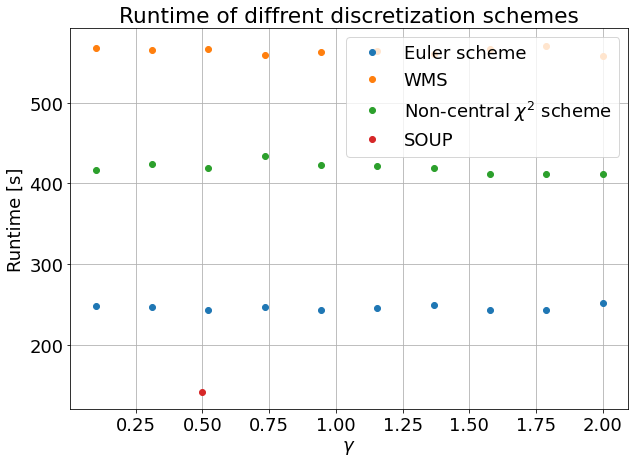

In [14]:
gammas = np.linspace(0.1,2,10)

plt.figure(figsize=(10,7))
plt.plot(gammas,t_euler,"o", label = "Euler scheme")
plt.plot(gammas,t_WMS,"o", label = "WMS")
plt.plot(gammas,t_Exact,"o", label = "Non-central $\chi^2$ scheme")
plt.plot(0.5,t_SOUP[0],"o", label = "SOUP")

plt.title("Runtime of different discretization schemes")
plt.legend(loc = "upper right")
plt.xlabel("$\gamma$")
plt.ylabel("Runtime [s]")
plt.grid()

---

### As a function of $dt$

In [15]:
model = 'CIR_'
name = 'Runtime_Euler'

print(f"\n\nStaring Experiment {model}{name}.\n")
t_euler = []

#Parameters:
Parameters = namedtuple('Parameters','X0 dt T kappa theta sigma')
P = Parameters(X0 = 0.5, dt = 0.0001, T = 1,kappa = 1, theta = 1, sigma = 2)

#Variables:
var_name = 'dt'
var = np.logspace(np.log10(0.1),np.log10(0.0001),10)


#Transforming the parameters into a more digestable form. This way the computation heavy part of the code needs less for cycles.
T = []
for i in range(len(var)):
  T.append([P.X0,var[i],P.T,P.kappa,P.theta,P.sigma])

start_time = time.time()
#GENERATING ALL TRAJECTORIES
X = np.zeros((len(T),mc_rep))
for i in range(len(T)):
  print(f"Making trajectories for X0 = {T[i][0]},dt = {T[i][1]},T = {T[i][2]},kappa = {T[i][3]},theta = {T[i][4]},sigma = {T[i][5]}.\n")

  s_time = time.time()
  n = 0
  for x in CIR_Prcss_mp(T[i][0],T[i][1],T[i][2],T[i][3],T[i][4],T[i][5]):
    X[i,n] = x
    n += 1
  e_time = time.time()

  t_euler.append(e_time-s_time)
  print(f"  Finished generating trajectories in {int((e_time-s_time)/60)} minutes and {e_time-s_time-int((e_time-s_time)/60)*60} seconds.[{i+1}/{len(T)}]\n")

#Memory Management
del T
del X

end_time = time.time()

print(f"The experiment finished in {int((end_time-start_time)/60)} minutes and {end_time-start_time-int((end_time-start_time)/60)*60} seconds.\n")



Staring Experiment CIR_Runtime_Euler.

Making trajectories for X0 = 0.5,dt = 0.1,T = 1,kappa = 1,theta = 1,sigma = 2.

  Finished generating trajectories in 0 minutes and 0.3587813377380371 seconds.[1/10]

Making trajectories for X0 = 0.5,dt = 0.046415888336127795,T = 1,kappa = 1,theta = 1,sigma = 2.

  Finished generating trajectories in 0 minutes and 0.6356167793273926 seconds.[2/10]

Making trajectories for X0 = 0.5,dt = 0.021544346900318846,T = 1,kappa = 1,theta = 1,sigma = 2.

  Finished generating trajectories in 0 minutes and 1.2968003749847412 seconds.[3/10]

Making trajectories for X0 = 0.5,dt = 0.01,T = 1,kappa = 1,theta = 1,sigma = 2.

  Finished generating trajectories in 0 minutes and 2.701352834701538 seconds.[4/10]

Making trajectories for X0 = 0.5,dt = 0.004641588833612782,T = 1,kappa = 1,theta = 1,sigma = 2.

  Finished generating trajectories in 0 minutes and 5.688209533691406 seconds.[5/10]

Making trajectories for X0 = 0.5,dt = 0.0021544346900318843,T = 1,kappa = 

In [16]:
model = 'CIR_'
name = 'Runtime_WMS'

print(f"\n\nStaring Experiment {model}{name}.\n")
t_WMS = []

#Parameters:
Parameters = namedtuple('Parameters','X0 dt T kappa theta sigma')
P = Parameters(X0 = 0.5, dt = 0.0001, T = 1,kappa = 1, theta = 1, sigma = 2)

#Variables:
var_name = 'dt'
var = np.logspace(np.log10(0.1),np.log10(0.0001),10)


#Transforming the parameters into a more digestable form. This way the computation heavy part of the code needs less for cycles.
T = []
for i in range(len(var)):
  T.append([P.X0,var[i],P.T,P.kappa,P.theta,P.sigma])

start_time = time.time()
#GENERATING ALL TRAJECTORIES
X = np.zeros((len(T),mc_rep))
for i in range(len(T)):
  print(f"Making trajectories for X0 = {T[i][0]},dt = {T[i][1]},T = {T[i][2]},kappa = {T[i][3]},theta = {T[i][4]},sigma = {T[i][5]}.\n")

  s_time = time.time()
  n = 0
  for x in CIR_Prcss_mp(T[i][0],T[i][1],T[i][2],T[i][3],T[i][4],T[i][5], WMS = "True"):
    X[i,n] = x
    n += 1
  e_time = time.time()

  t_WMS.append(e_time-s_time)
  print(f"  Finished generating trajectories in {int((e_time-s_time)/60)} minutes and {e_time-s_time-int((e_time-s_time)/60)*60} seconds.[{i+1}/{len(T)}]\n")

#Memory Management
del T
del X

end_time = time.time()

print(f"The experiment finished in {int((end_time-start_time)/60)} minutes and {end_time-start_time-int((end_time-start_time)/60)*60} seconds.\n")



Staring Experiment CIR_Runtime_WMS.

Making trajectories for X0 = 0.5,dt = 0.1,T = 1,kappa = 1,theta = 1,sigma = 2.

  Finished generating trajectories in 0 minutes and 0.7162637710571289 seconds.[1/10]

Making trajectories for X0 = 0.5,dt = 0.046415888336127795,T = 1,kappa = 1,theta = 1,sigma = 2.

  Finished generating trajectories in 0 minutes and 1.4586443901062012 seconds.[2/10]

Making trajectories for X0 = 0.5,dt = 0.021544346900318846,T = 1,kappa = 1,theta = 1,sigma = 2.

  Finished generating trajectories in 0 minutes and 3.113807201385498 seconds.[3/10]

Making trajectories for X0 = 0.5,dt = 0.01,T = 1,kappa = 1,theta = 1,sigma = 2.

  Finished generating trajectories in 0 minutes and 6.615115404129028 seconds.[4/10]

Making trajectories for X0 = 0.5,dt = 0.004641588833612782,T = 1,kappa = 1,theta = 1,sigma = 2.

  Finished generating trajectories in 0 minutes and 14.048248052597046 seconds.[5/10]

Making trajectories for X0 = 0.5,dt = 0.0021544346900318843,T = 1,kappa = 1,

In [17]:
model = 'CIR_'
name = 'Runtime_Exact'

print(f"\n\nStaring Experiment {model}{name}.\n")
t_Exact = []

#Parameters:
Parameters = namedtuple('Parameters','X0 dt T kappa theta sigma')
P = Parameters(X0 = 0.5, dt = 0.0001, T = 1,kappa = 1, theta = 1, sigma = 2)

#Variables:
var_name = 'dt'
var = np.logspace(np.log10(0.1),np.log10(0.0001),10)


#Transforming the parameters into a more digestable form. This way the computation heavy part of the code needs less for cycles.
T = []
for i in range(len(var)):
  T.append([P.X0,var[i],P.T,P.kappa,P.theta,P.sigma])

start_time = time.time()
#GENERATING ALL TRAJECTORIES
X = np.zeros((len(T),mc_rep))
for i in range(len(T)):
  print(f"Making trajectories for X0 = {T[i][0]},dt = {T[i][1]},T = {T[i][2]},kappa = {T[i][3]},theta = {T[i][4]},sigma = {T[i][5]}.\n")

  s_time = time.time()
  n = 0
  for x in CIR_Prcss_mp(T[i][0],T[i][1],T[i][2],T[i][3],T[i][4],T[i][5], Exact = "True"):
    X[i,n] = x
    n += 1
  e_time = time.time()

  t_Exact.append(e_time-s_time)
  print(f"  Finished generating trajectories in {int((e_time-s_time)/60)} minutes and {e_time-s_time-int((e_time-s_time)/60)*60} seconds.[{i+1}/{len(T)}]\n")

#Memory Management
del T
del X

end_time = time.time()

print(f"The experiment finished in {int((end_time-start_time)/60)} minutes and {end_time-start_time-int((end_time-start_time)/60)*60} seconds.\n")



Staring Experiment CIR_Runtime_Exact.

Making trajectories for X0 = 0.5,dt = 0.1,T = 1,kappa = 1,theta = 1,sigma = 2.

  Finished generating trajectories in 0 minutes and 0.642021656036377 seconds.[1/10]

Making trajectories for X0 = 0.5,dt = 0.046415888336127795,T = 1,kappa = 1,theta = 1,sigma = 2.

  Finished generating trajectories in 0 minutes and 1.239917516708374 seconds.[2/10]

Making trajectories for X0 = 0.5,dt = 0.021544346900318846,T = 1,kappa = 1,theta = 1,sigma = 2.

  Finished generating trajectories in 0 minutes and 2.594252824783325 seconds.[3/10]

Making trajectories for X0 = 0.5,dt = 0.01,T = 1,kappa = 1,theta = 1,sigma = 2.

  Finished generating trajectories in 0 minutes and 5.540524482727051 seconds.[4/10]

Making trajectories for X0 = 0.5,dt = 0.004641588833612782,T = 1,kappa = 1,theta = 1,sigma = 2.

  Finished generating trajectories in 0 minutes and 11.6241614818573 seconds.[5/10]

Making trajectories for X0 = 0.5,dt = 0.0021544346900318843,T = 1,kappa = 1,th

In [18]:
model = 'CIR_'
name = 'Runtime_SOUP'

print(f"\n\nStaring Experiment {model}{name}.\n")
t_SOUP = []

#Parameters:
Parameters = namedtuple('Parameters','X0 dt T kappa theta sigma')
P = Parameters(X0 = 0.5, dt = 0.0001, T = 1,kappa = 1, theta = 1, sigma = 2)

#Variables:
var_name = 'dt'
var = np.logspace(np.log10(0.1),np.log10(0.0001),10)


#Transforming the parameters into a more digestable form. This way the computation heavy part of the code needs less for cycles.
T = []
for i in range(len(var)):
  T.append([P.X0,var[i],P.T,P.kappa,P.theta,P.sigma])

start_time = time.time()
#GENERATING ALL TRAJECTORIES
X = np.zeros((len(T),mc_rep))
for i in range(len(T)):
  print(f"Making trajectories for X0 = {T[i][0]},dt = {T[i][1]},T = {T[i][2]},kappa = {T[i][3]},theta = {T[i][4]},sigma = {T[i][5]}.\n")

  s_time = time.time()
  n = 0
  for x in CIR_Prcss_mp(T[i][0],T[i][1],T[i][2],T[i][3],T[i][4],T[i][5], SOUP = "True"):
    X[i,n] = x
    n += 1
  e_time = time.time()

  t_SOUP.append(e_time-s_time)
  print(f"  Finished generating trajectories in {int((e_time-s_time)/60)} minutes and {e_time-s_time-int((e_time-s_time)/60)*60} seconds.[{i+1}/{len(T)}]\n")

#Memory Management
del T
del X

end_time = time.time()

print(f"The experiment finished in {int((end_time-start_time)/60)} minutes and {end_time-start_time-int((end_time-start_time)/60)*60} seconds.\n")



Staring Experiment CIR_Runtime_SOUP.

Making trajectories for X0 = 0.5,dt = 0.1,T = 1,kappa = 1,theta = 1,sigma = 2.

  Finished generating trajectories in 0 minutes and 0.2501370906829834 seconds.[1/10]

Making trajectories for X0 = 0.5,dt = 0.046415888336127795,T = 1,kappa = 1,theta = 1,sigma = 2.

  Finished generating trajectories in 0 minutes and 0.41148996353149414 seconds.[2/10]

Making trajectories for X0 = 0.5,dt = 0.021544346900318846,T = 1,kappa = 1,theta = 1,sigma = 2.

  Finished generating trajectories in 0 minutes and 0.7408688068389893 seconds.[3/10]

Making trajectories for X0 = 0.5,dt = 0.01,T = 1,kappa = 1,theta = 1,sigma = 2.

  Finished generating trajectories in 0 minutes and 1.496598720550537 seconds.[4/10]

Making trajectories for X0 = 0.5,dt = 0.004641588833612782,T = 1,kappa = 1,theta = 1,sigma = 2.

  Finished generating trajectories in 0 minutes and 3.021702766418457 seconds.[5/10]

Making trajectories for X0 = 0.5,dt = 0.0021544346900318843,T = 1,kappa = 

#### Results

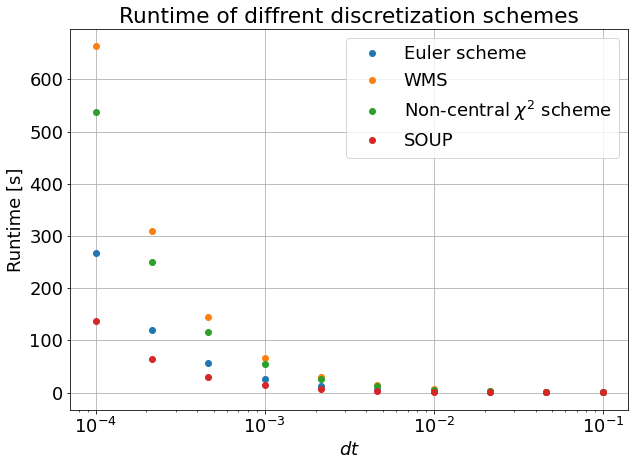

In [19]:
dts = np.logspace(np.log10(0.1),np.log10(0.0001),10)

plt.figure(figsize=(10,7))
plt.plot(dts,t_euler,"o", label = "Euler scheme")
plt.plot(dts,t_WMS,"o", label = "WMS")
plt.plot(dts,t_Exact,"o", label = "Non-central $\chi^2$ scheme")
plt.plot(dts,t_SOUP,"o", label = "SOUP")

plt.title("Runtime of different discretization schemes")
plt.legend()
plt.xlabel("$dt$")
plt.xscale("log")
plt.ylabel("Runtime [s]")
plt.grid()

---
---

## 2.) Evaluating the accuracy of the simulations using two sample Kolmogorov-Smirnov test

In [0]:
#Number of generated trajectories
mc_rep = 10000

### As a function of $\gamma$

In [22]:
model = 'CIR_'
name = 'Ktest_Exact'

print(f"\n\nStaring Experiment {model}{name}.\n")

#Parameters:
Parameters = namedtuple('Parameters','X0 dt T kappa theta sigma')
P = Parameters(X0 = 0.5, dt = 0.0001, T = 1,kappa = 1, theta = 1, sigma = 0.6)

#Variables:
var_name = 'gamma'
var = np.linspace(0.1,2,10)

sigma = list(map(lambda p: np.sqrt((2*P.kappa*P.theta)/p),var))

#Transforming the parameters into a more digestable form. This way the computation heavy part of the code needs less for cycles.
T = []
for i in range(len(var)):
  T.append([P.X0,P.dt,P.T,P.kappa,P.theta,sigma[i]])

start_time = time.time()
#GENERATING ALL TRAJECTORIES
X = np.zeros((len(T),mc_rep))
for i in range(len(T)):
  print(f"Making trajectories for X0 = {T[i][0]},dt = {T[i][1]},T = {T[i][2]},kappa = {T[i][3]},theta = {T[i][4]},sigma = {T[i][5]}.\n")

  s_time = time.time()
  n = 0
  for x in CIR_Prcss_mp(T[i][0],T[i][1],T[i][2],T[i][3],T[i][4],T[i][5], Exact = "True"):
    X[i,n] = x
    n += 1
  e_time = time.time()

  print(f"  Finished generating trajectories in {int((e_time-s_time)/60)} minutes and {e_time-s_time-int((e_time-s_time)/60)*60} seconds.[{i+1}/{len(T)}]\n")

#Memory Management
del T

end_time = time.time()

print(f"The experiment finished in {int((end_time-start_time)/60)} minutes and {end_time-start_time-int((end_time-start_time)/60)*60} seconds.\n")

Y = X



Staring Experiment CIR_Ktest_Exact.

Making trajectories for X0 = 0.5,dt = 0.0001,T = 1,kappa = 1,theta = 1,sigma = 4.47213595499958.

  Finished generating trajectories in 7 minutes and 1.3798916339874268 seconds.[1/10]

Making trajectories for X0 = 0.5,dt = 0.0001,T = 1,kappa = 1,theta = 1,sigma = 2.53546276418555.

  Finished generating trajectories in 6 minutes and 59.302241563797 seconds.[2/10]

Making trajectories for X0 = 0.5,dt = 0.0001,T = 1,kappa = 1,theta = 1,sigma = 1.9569842191603266.

  Finished generating trajectories in 7 minutes and 0.1849362850189209 seconds.[3/10]

Making trajectories for X0 = 0.5,dt = 0.0001,T = 1,kappa = 1,theta = 1,sigma = 1.651445647689541.

  Finished generating trajectories in 6 minutes and 57.95248460769653 seconds.[4/10]

Making trajectories for X0 = 0.5,dt = 0.0001,T = 1,kappa = 1,theta = 1,sigma = 1.4552137502179978.

  Finished generating trajectories in 6 minutes and 59.40630102157593 seconds.[5/10]

Making trajectories for X0 = 0.5,dt 

In [23]:
model = 'CIR_'
name = 'Ktest_Euler'

print(f"\n\nStaring Experiment {model}{name}.\n")

#Parameters:
Parameters = namedtuple('Parameters','X0 dt T kappa theta sigma')
P = Parameters(X0 = 0.5, dt = 0.0001, T = 1,kappa = 1, theta = 1, sigma = 0.6)

#Variables:
var_name = 'gamma'
var = np.linspace(0.1,2,10)

sigma = list(map(lambda p: np.sqrt((2*P.kappa*P.theta)/p),var))

#Transforming the parameters into a more digestable form. This way the computation heavy part of the code needs less for cycles.
T = []
for i in range(len(var)):
  T.append([P.X0,P.dt,P.T,P.kappa,P.theta,sigma[i]])

start_time = time.time()
#GENERATING ALL TRAJECTORIES
X = np.zeros((len(T),mc_rep))
for i in range(len(T)):
  print(f"Making trajectories for X0 = {T[i][0]},dt = {T[i][1]},T = {T[i][2]},kappa = {T[i][3]},theta = {T[i][4]},sigma = {T[i][5]}.\n")

  s_time = time.time()
  n = 0
  for x in CIR_Prcss_mp(T[i][0],T[i][1],T[i][2],T[i][3],T[i][4],T[i][5]):
    X[i,n] = x
    n += 1
  e_time = time.time()

  print(f"  Finished generating trajectories in {int((e_time-s_time)/60)} minutes and {e_time-s_time-int((e_time-s_time)/60)*60} seconds.[{i+1}/{len(T)}]\n")

#Memory Management
del T

end_time = time.time()

print(f"The experiment finished in {int((end_time-start_time)/60)} minutes and {end_time-start_time-int((end_time-start_time)/60)*60} seconds.\n")



Staring Experiment CIR_Ktest_Euler.

Making trajectories for X0 = 0.5,dt = 0.0001,T = 1,kappa = 1,theta = 1,sigma = 4.47213595499958.

  Finished generating trajectories in 3 minutes and 59.950456857681274 seconds.[1/10]

Making trajectories for X0 = 0.5,dt = 0.0001,T = 1,kappa = 1,theta = 1,sigma = 2.53546276418555.

  Finished generating trajectories in 4 minutes and 1.006497859954834 seconds.[2/10]

Making trajectories for X0 = 0.5,dt = 0.0001,T = 1,kappa = 1,theta = 1,sigma = 1.9569842191603266.

  Finished generating trajectories in 3 minutes and 59.39592432975769 seconds.[3/10]

Making trajectories for X0 = 0.5,dt = 0.0001,T = 1,kappa = 1,theta = 1,sigma = 1.651445647689541.

  Finished generating trajectories in 4 minutes and 0.3816990852355957 seconds.[4/10]

Making trajectories for X0 = 0.5,dt = 0.0001,T = 1,kappa = 1,theta = 1,sigma = 1.4552137502179978.

  Finished generating trajectories in 3 minutes and 59.75041580200195 seconds.[5/10]

Making trajectories for X0 = 0.5,d

In [0]:
pval_Euler = []
for i in range(len(Y)):
  pval_Euler.append(list(ks_2samp(X[i],Y[i]))[1])

In [25]:
model = 'CIR_'
name = 'Ktest_WMS'

print(f"\n\nStaring Experiment {model}{name}.\n")

#Parameters:
Parameters = namedtuple('Parameters','X0 dt T kappa theta sigma')
P = Parameters(X0 = 0.5, dt = 0.0001, T = 1,kappa = 1, theta = 1, sigma = 0.6)

#Variables:
var_name = 'gamma'
var = np.linspace(0.1,2,10)

sigma = list(map(lambda p: np.sqrt((2*P.kappa*P.theta)/p),var))

#Transforming the parameters into a more digestable form. This way the computation heavy part of the code needs less for cycles.
T = []
for i in range(len(var)):
  T.append([P.X0,P.dt,P.T,P.kappa,P.theta,sigma[i]])

start_time = time.time()
#GENERATING ALL TRAJECTORIES
X = np.zeros((len(T),mc_rep))
for i in range(len(T)):
  print(f"Making trajectories for X0 = {T[i][0]},dt = {T[i][1]},T = {T[i][2]},kappa = {T[i][3]},theta = {T[i][4]},sigma = {T[i][5]}.\n")

  s_time = time.time()
  n = 0
  for x in CIR_Prcss_mp(T[i][0],T[i][1],T[i][2],T[i][3],T[i][4],T[i][5], WMS = "True"):
    X[i,n] = x
    n += 1
  e_time = time.time()

  print(f"  Finished generating trajectories in {int((e_time-s_time)/60)} minutes and {e_time-s_time-int((e_time-s_time)/60)*60} seconds.[{i+1}/{len(T)}]\n")

#Memory Management
del T

end_time = time.time()

print(f"The experiment finished in {int((end_time-start_time)/60)} minutes and {end_time-start_time-int((end_time-start_time)/60)*60} seconds.\n")



Staring Experiment CIR_Ktest_WMS.

Making trajectories for X0 = 0.5,dt = 0.0001,T = 1,kappa = 1,theta = 1,sigma = 4.47213595499958.

  Finished generating trajectories in 9 minutes and 25.289709091186523 seconds.[1/10]

Making trajectories for X0 = 0.5,dt = 0.0001,T = 1,kappa = 1,theta = 1,sigma = 2.53546276418555.

  Finished generating trajectories in 9 minutes and 16.48362898826599 seconds.[2/10]

Making trajectories for X0 = 0.5,dt = 0.0001,T = 1,kappa = 1,theta = 1,sigma = 1.9569842191603266.

  Finished generating trajectories in 9 minutes and 21.528730869293213 seconds.[3/10]

Making trajectories for X0 = 0.5,dt = 0.0001,T = 1,kappa = 1,theta = 1,sigma = 1.651445647689541.

  Finished generating trajectories in 9 minutes and 21.89885663986206 seconds.[4/10]

Making trajectories for X0 = 0.5,dt = 0.0001,T = 1,kappa = 1,theta = 1,sigma = 1.4552137502179978.

  Finished generating trajectories in 9 minutes and 28.567232131958008 seconds.[5/10]

Making trajectories for X0 = 0.5,dt

In [0]:
pval_WMS = []
for i in range(len(Y)):
  pval_WMS.append(list(ks_2samp(X[i],Y[i]))[1])

del X
del Y

#### Results

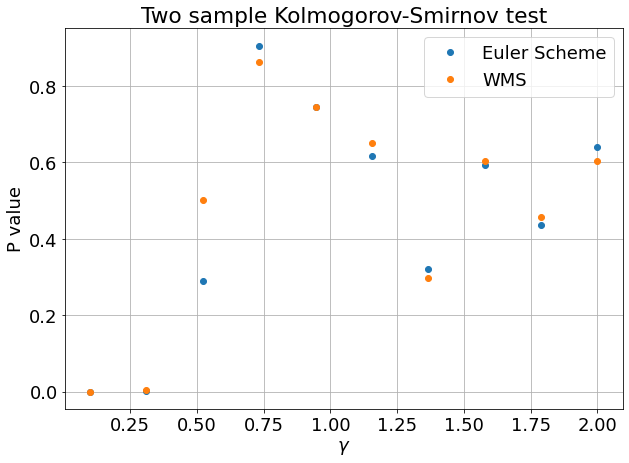

In [28]:
gammas = np.linspace(0.1,2,10)

plt.figure(figsize=(10,7))
plt.plot(gammas,pval_Euler,"o", label = "Euler Scheme")
plt.plot(gammas,pval_WMS,"o", label = "WMS")

plt.title("Two sample Kolmogorov-Smirnov test")
plt.legend()
plt.xlabel("$\gamma$")
plt.ylabel("P value")
plt.grid()

---

### As a function of $dt$

In [29]:
model = 'CIR_'
name = 'Ktest_Exact'

print(f"\n\nStaring Experiment {model}{name}.\n")

#Parameters:
Parameters = namedtuple('Parameters','X0 dt T kappa theta sigma')
P = Parameters(X0 = 0.5, dt = 0.01, T = 1,kappa = 1, theta = 1, sigma = 1)

#Variables:
var_name = 'dt'
var = np.logspace(np.log10(0.1),np.log10(0.0001),10)


#Transforming the parameters into a more digestable form. This way the computation heavy part of the code needs less for cycles.
T = []
for i in range(len(var)):
  T.append([P.X0,var[i],P.T,P.kappa,P.theta,P.sigma])

start_time = time.time()
#GENERATING ALL TRAJECTORIES
X = np.zeros((len(T),mc_rep))
for i in range(len(T)):
  print(f"Making trajectories for X0 = {T[i][0]},dt = {T[i][1]},T = {T[i][2]},kappa = {T[i][3]},theta = {T[i][4]},sigma = {T[i][5]}.\n")

  s_time = time.time()
  n = 0
  for x in CIR_Prcss_mp(T[i][0],T[i][1],T[i][2],T[i][3],T[i][4],T[i][5], Exact = "True"):
    X[i,n] = x
    n += 1
  e_time = time.time()

  print(f"  Finished generating trajectories in {int((e_time-s_time)/60)} minutes and {e_time-s_time-int((e_time-s_time)/60)*60} seconds.[{i+1}/{len(T)}]\n")

#Memory Management
del T

end_time = time.time()

print(f"The experiment finished in {int((end_time-start_time)/60)} minutes and {end_time-start_time-int((end_time-start_time)/60)*60} seconds.\n")

Y = X



Staring Experiment CIR_Ktest_Exact.

Making trajectories for X0 = 0.5,dt = 0.1,T = 1,kappa = 1,theta = 1,sigma = 1.

  Finished generating trajectories in 0 minutes and 0.635094165802002 seconds.[1/10]

Making trajectories for X0 = 0.5,dt = 0.046415888336127795,T = 1,kappa = 1,theta = 1,sigma = 1.

  Finished generating trajectories in 0 minutes and 1.212923526763916 seconds.[2/10]

Making trajectories for X0 = 0.5,dt = 0.021544346900318846,T = 1,kappa = 1,theta = 1,sigma = 1.

  Finished generating trajectories in 0 minutes and 2.569878101348877 seconds.[3/10]

Making trajectories for X0 = 0.5,dt = 0.01,T = 1,kappa = 1,theta = 1,sigma = 1.

  Finished generating trajectories in 0 minutes and 5.40955924987793 seconds.[4/10]

Making trajectories for X0 = 0.5,dt = 0.004641588833612782,T = 1,kappa = 1,theta = 1,sigma = 1.

  Finished generating trajectories in 0 minutes and 11.542599439620972 seconds.[5/10]

Making trajectories for X0 = 0.5,dt = 0.0021544346900318843,T = 1,kappa = 1,the

In [30]:
model = 'CIR_'
name = 'Ktest_Euler'

print(f"\n\nStaring Experiment {model}{name}.\n")

#Parameters:
Parameters = namedtuple('Parameters','X0 dt T kappa theta sigma')
P = Parameters(X0 = 0.5, dt = 0.01, T = 1,kappa = 1, theta = 1, sigma = 1)

#Variables:
var_name = 'dt'
var = np.logspace(np.log10(0.1),np.log10(0.0001),10)

#Transforming the parameters into a more digestable form. This way the computation heavy part of the code needs less for cycles.
T = []
for i in range(len(var)):
  T.append([P.X0,var[i],P.T,P.kappa,P.theta,P.sigma])

start_time = time.time()
#GENERATING ALL TRAJECTORIES
X = np.zeros((len(T),mc_rep))
for i in range(len(T)):
  print(f"Making trajectories for X0 = {T[i][0]},dt = {T[i][1]},T = {T[i][2]},kappa = {T[i][3]},theta = {T[i][4]},sigma = {T[i][5]}.\n")

  s_time = time.time()
  n = 0
  for x in CIR_Prcss_mp(T[i][0],T[i][1],T[i][2],T[i][3],T[i][4],T[i][5]):
    X[i,n] = x
    n += 1
  e_time = time.time()

  print(f"  Finished generating trajectories in {int((e_time-s_time)/60)} minutes and {e_time-s_time-int((e_time-s_time)/60)*60} seconds.[{i+1}/{len(T)}]\n")

#Memory Management
del T

end_time = time.time()

print(f"The experiment finished in {int((end_time-start_time)/60)} minutes and {end_time-start_time-int((end_time-start_time)/60)*60} seconds.\n")



Staring Experiment CIR_Ktest_Euler.

Making trajectories for X0 = 0.5,dt = 0.1,T = 1,kappa = 1,theta = 1,sigma = 1.

  Finished generating trajectories in 0 minutes and 0.3564107418060303 seconds.[1/10]

Making trajectories for X0 = 0.5,dt = 0.046415888336127795,T = 1,kappa = 1,theta = 1,sigma = 1.

  Finished generating trajectories in 0 minutes and 0.639336347579956 seconds.[2/10]

Making trajectories for X0 = 0.5,dt = 0.021544346900318846,T = 1,kappa = 1,theta = 1,sigma = 1.

  Finished generating trajectories in 0 minutes and 1.2942180633544922 seconds.[3/10]

Making trajectories for X0 = 0.5,dt = 0.01,T = 1,kappa = 1,theta = 1,sigma = 1.

  Finished generating trajectories in 0 minutes and 2.7007336616516113 seconds.[4/10]

Making trajectories for X0 = 0.5,dt = 0.004641588833612782,T = 1,kappa = 1,theta = 1,sigma = 1.

  Finished generating trajectories in 0 minutes and 5.608321666717529 seconds.[5/10]

Making trajectories for X0 = 0.5,dt = 0.0021544346900318843,T = 1,kappa = 1,

In [0]:
pval_Euler = []
for i in range(len(Y)):
  pval_Euler.append(list(ks_2samp(X[i],Y[i]))[1])

In [32]:
model = 'CIR_'
name = 'Ktest_WMS'

print(f"\n\nStaring Experiment {model}{name}.\n")

#Parameters:
Parameters = namedtuple('Parameters','X0 dt T kappa theta sigma')
P = Parameters(X0 = 0.5, dt = 0.01, T = 1,kappa = 1, theta = 1, sigma = 1)

#Variables:
var_name = 'dt'
var = np.logspace(np.log10(0.1),np.log10(0.0001),10)

#Transforming the parameters into a more digestable form. This way the computation heavy part of the code needs less for cycles.
T = []
for i in range(len(var)):
  T.append([P.X0,var[i],P.T,P.kappa,P.theta,P.sigma])

start_time = time.time()
#GENERATING ALL TRAJECTORIES
X = np.zeros((len(T),mc_rep))
for i in range(len(T)):
  print(f"Making trajectories for X0 = {T[i][0]},dt = {T[i][1]},T = {T[i][2]},kappa = {T[i][3]},theta = {T[i][4]},sigma = {T[i][5]}.\n")

  s_time = time.time()
  n = 0
  for x in CIR_Prcss_mp(T[i][0],T[i][1],T[i][2],T[i][3],T[i][4],T[i][5], WMS = "True"):
    X[i,n] = x
    n += 1
  e_time = time.time()

  print(f"  Finished generating trajectories in {int((e_time-s_time)/60)} minutes and {e_time-s_time-int((e_time-s_time)/60)*60} seconds.[{i+1}/{len(T)}]\n")

#Memory Management
del T

end_time = time.time()

print(f"The experiment finished in {int((end_time-start_time)/60)} minutes and {end_time-start_time-int((end_time-start_time)/60)*60} seconds.\n")



Staring Experiment CIR_Ktest_WMS.

Making trajectories for X0 = 0.5,dt = 0.1,T = 1,kappa = 1,theta = 1,sigma = 1.

  Finished generating trajectories in 0 minutes and 0.7091069221496582 seconds.[1/10]

Making trajectories for X0 = 0.5,dt = 0.046415888336127795,T = 1,kappa = 1,theta = 1,sigma = 1.

  Finished generating trajectories in 0 minutes and 1.4694843292236328 seconds.[2/10]

Making trajectories for X0 = 0.5,dt = 0.021544346900318846,T = 1,kappa = 1,theta = 1,sigma = 1.

  Finished generating trajectories in 0 minutes and 3.109330654144287 seconds.[3/10]

Making trajectories for X0 = 0.5,dt = 0.01,T = 1,kappa = 1,theta = 1,sigma = 1.

  Finished generating trajectories in 0 minutes and 6.628569602966309 seconds.[4/10]

Making trajectories for X0 = 0.5,dt = 0.004641588833612782,T = 1,kappa = 1,theta = 1,sigma = 1.

  Finished generating trajectories in 0 minutes and 14.142427682876587 seconds.[5/10]

Making trajectories for X0 = 0.5,dt = 0.0021544346900318843,T = 1,kappa = 1,th

In [0]:
pval_WMS = []
for i in range(len(Y)):
  pval_WMS.append(list(ks_2samp(X[i],Y[i]))[1])

del X
del Y

#### Results

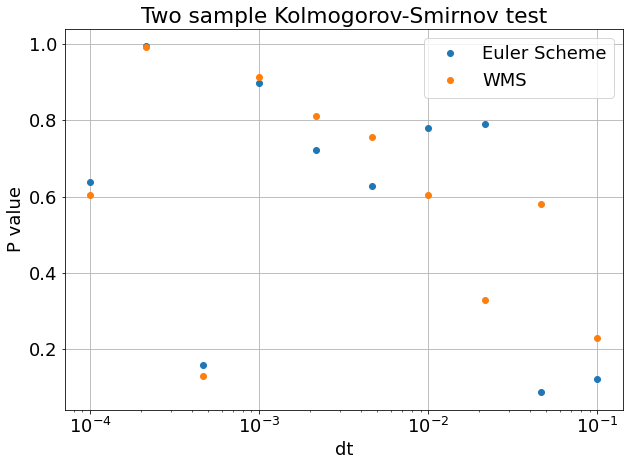

In [34]:
gammas = np.logspace(np.log10(0.1),np.log10(0.0001),10)

plt.figure(figsize=(10,7))
plt.plot(gammas,pval_Euler,"o", label = "Euler Scheme")
plt.plot(gammas,pval_WMS,"o", label = "WMS")

plt.title("Two sample Kolmogorov-Smirnov test")
plt.legend()
plt.xlabel("dt")
plt.ylabel("P value")
plt.xscale("log")
plt.grid()

---
---

## 3.) Measuring the time to cross the barriers
Lower barrier: $0$

Upper barrier $2 X_0$

In [0]:
#Number of generated trajectories
mc_rep = 10000

In [0]:
model = 'CIR_'
name = 'full_Exact'

print(f"\n\nStaring Experiment {model}{name}.\n")

#Parameters:
Parameters = namedtuple('Parameters','X0 dt T kappa theta sigma')
P = Parameters(X0 = 0.5, dt = 0.0001, T = 2,kappa = 1, theta = 1, sigma = 0.6)

#Variables:
var_name = 'gamma'
var = [0.1,3]

sigma = list(map(lambda p: np.sqrt((2*P.kappa*P.theta)/p),var))

#Transforming the parameters into a more digestable form. This way the computation heavy part of the code needs less for cycles.
T = []
for i in range(len(var)):
  T.append([P.X0,P.dt,P.T,P.kappa,P.theta,sigma[i]])

start_time = time.time()
#GENERATING ALL TRAJECTORIES
X = []
for i in range(len(T)):
  print(f"Making trajectories for X0 = {T[i][0]},dt = {T[i][1]},T = {T[i][2]},kappa = {T[i][3]},theta = {T[i][4]},sigma = {T[i][5]}.\n")

  s_time = time.time()
  X.append(CIR_Prcss_mp(T[i][0],T[i][1],T[i][2],T[i][3],T[i][4],T[i][5], Exact = "True", Path = "True"))
  e_time = time.time()

  print(f"  Finished generating trajectories in {int((e_time-s_time)/60)} minutes and {e_time-s_time-int((e_time-s_time)/60)*60} seconds.[{i+1}/{len(T)}]\n")

#Memory Management
del T

end_time = time.time()

print(f"The experiment finished in {int((end_time-start_time)/60)} minutes and {end_time-start_time-int((end_time-start_time)/60)*60} seconds.\n")



Staring Experiment CIR_full_Exact.

Making trajectories for X0 = 0.5,dt = 0.0001,T = 2,kappa = 1,theta = 1,sigma = 4.47213595499958.

  Finished generating trajectories in 16 minutes and 28.377679586410522 seconds.[1/2]

Making trajectories for X0 = 0.5,dt = 0.0001,T = 2,kappa = 1,theta = 1,sigma = 0.816496580927726.

  Finished generating trajectories in 15 minutes and 35.99169325828552 seconds.[2/2]

The experiment finished in 32 minutes and 4.371639013290405 seconds.



In [0]:
#X[0] ---> under gammac
#X[1] ---> above gammac

In [0]:
tau0s_u = []
tau2X0s_u = []

for i in range(len(X[0])):
  tau0 = 1
  tau2X0 = 1
  t = 0
  for j in range(len(X[0][i])):
    if (X[0][i][j] < 0.0001) & (t <= tau0):
      tau0 = t
    elif (X[0][i][j] >= 1) & (t <= tau2X0):
      tau2X0 = t
    t += 0.0001
  if tau0 > tau2X0:
    tau2X0s_u.append(tau2X0)
  else:
    tau0s_u.append(tau0)

In [0]:
tau0s_a = []
tau2X0s_a = []

for i in range(len(X[1])):
  tau0 = 1
  tau2X0 = 1
  t = 0
  for j in range(len(X[1][i])):
    if (X[1][i][j] < 0.0001) & (t <= tau0):
      tau0 = t
    elif (X[1][i][j] >= 1) & (t <= tau2X0):
      tau2X0 = t
    t += 0.0001
  if tau0 > tau2X0:
    tau2X0s_a.append(tau2X0)
  else:
    tau0s_a.append(tau0)

### Results

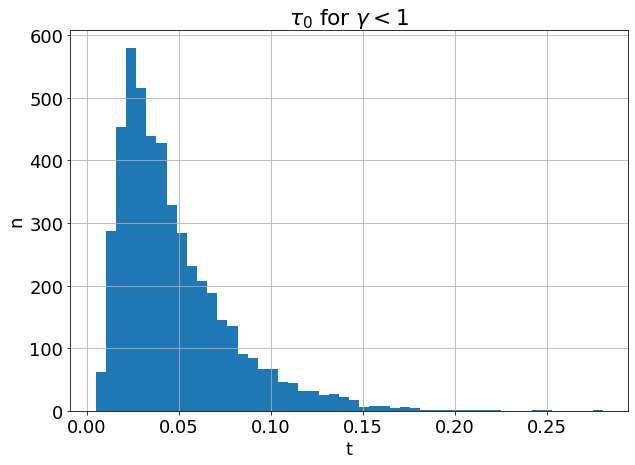

In [0]:
plt.figure(figsize=(10,7))
hist, bins, patches = plt.hist(tau0s_u,bins = 50)

plt.title("$\\tau_0$ for $\gamma < 1$")
plt.xlabel("t")
plt.ylabel("n")
plt.grid()

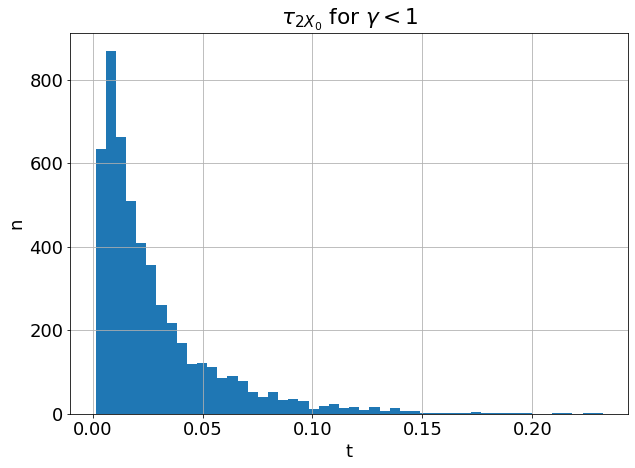

In [0]:
plt.figure(figsize=(10,7))
hist, bins, patches = plt.hist(tau2X0s_u, bins = 50)

plt.title("$\\tau_{2X_0}$ for $\gamma < 1$")
plt.xlabel("t")
plt.ylabel("n")
plt.grid()

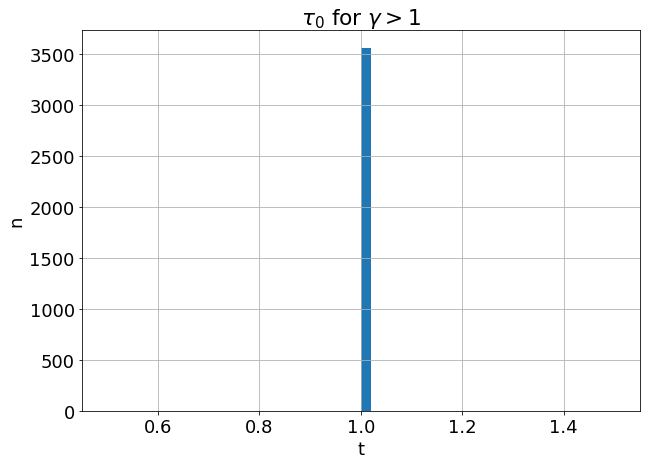

In [0]:
plt.figure(figsize=(10,7))
hist, bins, patches = plt.hist(tau0s_a, bins = 50)

plt.title("$\\tau_0$ for $\gamma > 1$")
plt.xlabel("t")
plt.ylabel("n")
plt.grid()

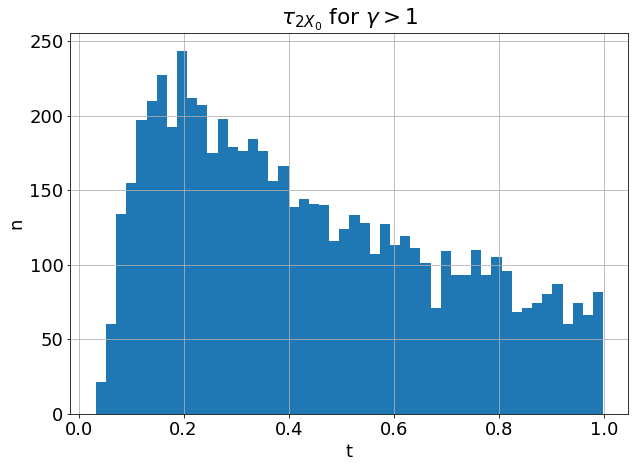

In [0]:
plt.figure(figsize=(10,7))
hist, bins, patches = plt.hist(tau2X0s_a, bins = 50)

plt.title("$\\tau_{2X_0}$ for $\gamma > 1$")
plt.xlabel("t")
plt.ylabel("n")
plt.grid()

---
---

## 4.) Simulating the special case of $\gamma = \frac{1}{2}$ as a squared Ornstein-Uhlenbeck process

In [0]:
#Number of generated trajectories
mc_rep = 10000

---

In [0]:
model = 'CIR_'
name = 'OUP'

print(f"\n\nStaring Experiment {model}{name}.\n")

#Parameters:
Parameters = namedtuple('Parameters','X0 dt T kappa theta sigma')
P = Parameters(X0 = 0.5, dt = 0.0001, T = 1,kappa = 1, theta = 1, sigma = 1)

#Variables:
var_name = 'gamma'
var = [0.5]

sigma = list(map(lambda p: np.sqrt((2*P.kappa*P.theta)/p),var))


#Transforming the parameters into a more digestable form. This way the computation heavy part of the code needs less for cycles.
T = []
for i in range(len(var)):
  T.append([P.X0,P.dt,P.T,P.kappa,P.theta,sigma[i]])

start_time = time.time()
#GENERATING ALL TRAJECTORIES
X_OUP = []
for i in range(len(T)):
  print(f"Making trajectories for X0 = {T[i][0]},dt = {T[i][1]},T = {T[i][2]},kappa = {T[i][3]},theta = {T[i][4]},sigma = {T[i][5]}.\n")

  s_time = time.time()
  X_OUP.append(CIR_Prcss_mp(T[i][0],T[i][1],T[i][2],T[i][3],T[i][4],T[i][5], SOUP = True, OUP = True))
  e_time = time.time()

  print(f"  Finished generating trajectories in {int((e_time-s_time)/60)} minutes and {e_time-s_time-int((e_time-s_time)/60)*60} seconds.[{i+1}/{len(T)}]\n")

#Memory Management
del T

end_time = time.time()

print(f"The experiment finished in {int((end_time-start_time)/60)} minutes and {end_time-start_time-int((end_time-start_time)/60)*60} seconds.\n")



Staring Experiment CIR_OUP.

Making trajectories for X0 = 0.5,dt = 0.0001,T = 1,kappa = 1,theta = 1,sigma = 2.0.

  Finished generating trajectories in 2 minutes and 20.01419448852539 seconds.[1/1]

The experiment finished in 2 minutes and 20.01621985435486 seconds.



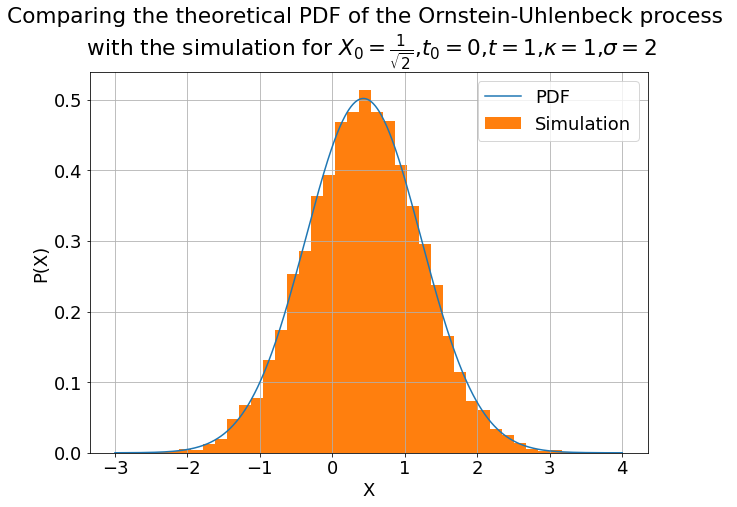

In [0]:
plt.figure(figsize=(10,7))

xrange = np.linspace(-3,4,1000)
plt.plot(xrange,f(xrange))

n,bins,patches = plt.hist(X_OUP,bins = 38, density = True)

plt.title("Comparing the theoretical PDF of the Ornstein-Uhlenbeck process \n with the simulation for $X_0 = \\frac{1}{\sqrt{2}}$,$t_0 = 0$,$t=1$,$\kappa =1$,$\sigma =2$")
plt.legend(("PDF","Simulation"))
plt.xlabel("X")
plt.ylabel("P(X)")
plt.grid()

---

In [0]:
model = 'CIR_'
name = 'SOUP'

print(f"\n\nStaring Experiment {model}{name}.\n")

#Parameters:
Parameters = namedtuple('Parameters','X0 dt T kappa theta sigma')
P = Parameters(X0 = 0.5, dt = 0.0001, T = 1,kappa = 1, theta = 1, sigma = 1)

#Variables:
var_name = 'gamma'
var = [0.5]

sigma = list(map(lambda p: np.sqrt((2*P.kappa*P.theta)/p),var))


#Transforming the parameters into a more digestable form. This way the computation heavy part of the code needs less for cycles.
T = []
for i in range(len(var)):
  T.append([P.X0,P.dt,P.T,P.kappa,P.theta,sigma[i]])

start_time = time.time()
#GENERATING ALL TRAJECTORIES
X_SOUP = []
for i in range(len(T)):
  print(f"Making trajectories for X0 = {T[i][0]},dt = {T[i][1]},T = {T[i][2]},kappa = {T[i][3]},theta = {T[i][4]},sigma = {T[i][5]}.\n")

  s_time = time.time()
  X_SOUP.append(CIR_Prcss_mp(T[i][0],T[i][1],T[i][2],T[i][3],T[i][4],T[i][5], SOUP = "True"))
  e_time = time.time()

  print(f"  Finished generating trajectories in {int((e_time-s_time)/60)} minutes and {e_time-s_time-int((e_time-s_time)/60)*60} seconds.[{i+1}/{len(T)}]\n")

#Memory Management
del T

end_time = time.time()

print(f"The experiment finished in {int((end_time-start_time)/60)} minutes and {end_time-start_time-int((end_time-start_time)/60)*60} seconds.\n")



Staring Experiment CIR_SOUP.

Making trajectories for X0 = 0.5,dt = 0.0001,T = 1,kappa = 1,theta = 1,sigma = 2.0.

  Finished generating trajectories in 2 minutes and 21.25276017189026 seconds.[1/1]

The experiment finished in 2 minutes and 21.25489330291748 seconds.



In [0]:
model = 'CIR_'
name = 'WMS'

print(f"\n\nStaring Experiment {model}{name}.\n")

#Parameters:
Parameters = namedtuple('Parameters','X0 dt T kappa theta sigma')
P = Parameters(X0 = 0.5, dt = 0.0001, T = 1,kappa = 1, theta = 1, sigma = 1)

#Variables:
var_name = 'gamma'
var = [0.5]

sigma = list(map(lambda p: np.sqrt((2*P.kappa*P.theta)/p),var))


#Transforming the parameters into a more digestable form. This way the computation heavy part of the code needs less for cycles.
T = []
for i in range(len(var)):
  T.append([P.X0,P.dt,P.T,P.kappa,P.theta,sigma[i]])

start_time = time.time()
#GENERATING ALL TRAJECTORIES
X_WMS = []
for i in range(len(T)):
  print(f"Making trajectories for X0 = {T[i][0]},dt = {T[i][1]},T = {T[i][2]},kappa = {T[i][3]},theta = {T[i][4]},sigma = {T[i][5]}.\n")

  s_time = time.time()
  X_WMS.append(CIR_Prcss_mp(T[i][0],T[i][1],T[i][2],T[i][3],T[i][4],T[i][5], WMS = "True"))
  e_time = time.time()

  print(f"  Finished generating trajectories in {int((e_time-s_time)/60)} minutes and {e_time-s_time-int((e_time-s_time)/60)*60} seconds.[{i+1}/{len(T)}]\n")

#Memory Management
del T

end_time = time.time()

print(f"The experiment finished in {int((end_time-start_time)/60)} minutes and {end_time-start_time-int((end_time-start_time)/60)*60} seconds.\n")



Staring Experiment CIR_WMS.

Making trajectories for X0 = 0.5,dt = 0.0001,T = 1,kappa = 1,theta = 1,sigma = 2.0.

  Finished generating trajectories in 10 minutes and 1.491384506225586 seconds.[1/1]

The experiment finished in 10 minutes and 1.4933476448059082 seconds.



In [0]:
model = 'CIR_'
name = 'Euler'

print(f"\n\nStaring Experiment {model}{name}.\n")

#Parameters:
Parameters = namedtuple('Parameters','X0 dt T kappa theta sigma')
P = Parameters(X0 = 0.5, dt = 0.0001, T = 1,kappa = 1, theta = 1, sigma = 1)

#Variables:
var_name = 'gamma'
var = [0.5]

sigma = list(map(lambda p: np.sqrt((2*P.kappa*P.theta)/p),var))


#Transforming the parameters into a more digestable form. This way the computation heavy part of the code needs less for cycles.
T = []
for i in range(len(var)):
  T.append([P.X0,P.dt,P.T,P.kappa,P.theta,sigma[i]])

start_time = time.time()
#GENERATING ALL TRAJECTORIES
X_Euler = []
for i in range(len(T)):
  print(f"Making trajectories for X0 = {T[i][0]},dt = {T[i][1]},T = {T[i][2]},kappa = {T[i][3]},theta = {T[i][4]},sigma = {T[i][5]}.\n")

  s_time = time.time()
  X_Euler.append(CIR_Prcss_mp(T[i][0],T[i][1],T[i][2],T[i][3],T[i][4],T[i][5]))
  e_time = time.time()

  print(f"  Finished generating trajectories in {int((e_time-s_time)/60)} minutes and {e_time-s_time-int((e_time-s_time)/60)*60} seconds.[{i+1}/{len(T)}]\n")

#Memory Management
del T

end_time = time.time()

print(f"The experiment finished in {int((end_time-start_time)/60)} minutes and {end_time-start_time-int((end_time-start_time)/60)*60} seconds.\n")



Staring Experiment CIR_Euler.

Making trajectories for X0 = 0.5,dt = 0.0001,T = 1,kappa = 1,theta = 1,sigma = 2.0.

  Finished generating trajectories in 4 minutes and 12.656699657440186 seconds.[1/1]

The experiment finished in 4 minutes and 12.657903909683228 seconds.



In [0]:
model = 'CIR_'
name = 'Exact'

print(f"\n\nStaring Experiment {model}{name}.\n")

#Parameters:
Parameters = namedtuple('Parameters','X0 dt T kappa theta sigma')
P = Parameters(X0 = 0.5, dt = 0.0001, T = 1,kappa = 1, theta = 1, sigma = 1)

#Variables:
var_name = 'gamma'
var = [0.5]

sigma = list(map(lambda p: np.sqrt((2*P.kappa*P.theta)/p),var))


#Transforming the parameters into a more digestable form. This way the computation heavy part of the code needs less for cycles.
T = []
for i in range(len(var)):
  T.append([P.X0,P.dt,P.T,P.kappa,P.theta,sigma[i]])

start_time = time.time()
#GENERATING ALL TRAJECTORIES
X_Exact = []
for i in range(len(T)):
  print(f"Making trajectories for X0 = {T[i][0]},dt = {T[i][1]},T = {T[i][2]},kappa = {T[i][3]},theta = {T[i][4]},sigma = {T[i][5]}.\n")

  s_time = time.time()
  X_Exact.append(CIR_Prcss_mp(T[i][0],T[i][1],T[i][2],T[i][3],T[i][4],T[i][5], Exact = True))
  e_time = time.time()

  print(f"  Finished generating trajectories in {int((e_time-s_time)/60)} minutes and {e_time-s_time-int((e_time-s_time)/60)*60} seconds.[{i+1}/{len(T)}]\n")

#Memory Management
del T

end_time = time.time()

print(f"The experiment finished in {int((end_time-start_time)/60)} minutes and {end_time-start_time-int((end_time-start_time)/60)*60} seconds.\n")



Staring Experiment CIR_Exact.

Making trajectories for X0 = 0.5,dt = 0.0001,T = 1,kappa = 1,theta = 1,sigma = 2.0.

  Finished generating trajectories in 7 minutes and 25.659267902374268 seconds.[1/1]

The experiment finished in 7 minutes and 25.661768674850464 seconds.



---

### Results

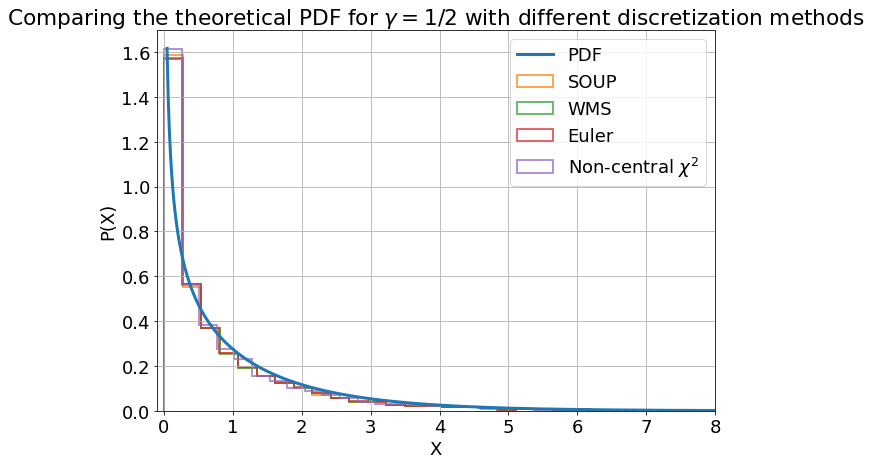

In [0]:
plt.figure(figsize=(10,7))

xrange = np.linspace(0.045,8,1000)
plt.plot(xrange,g(xrange), lw = 3)

n,bins,patches = plt.hist(X_SOUP,bins = 50, density = True, histtype='step', lw = 2, alpha = 0.7)
n,bins,patches = plt.hist(X_WMS,bins = 50, density = True, histtype='step', lw = 2, alpha = 0.7)
n,bins,patches = plt.hist(X_Euler,bins = 50, density = True, histtype='step', lw = 2, alpha = 0.7)
n,bins,patches = plt.hist(X_Exact[0], bins = 50, density =  True, histtype='step', lw = 2, alpha = 0.7)

plt.xlim((-0.1,8))

plt.title("Comparing the theoretical PDF for $\gamma = 1/2$ with different discretization methods")
plt.legend(("PDF","SOUP","WMS","Euler","Non-central $\chi^2$"))
plt.xlabel("X")
plt.ylabel("P(X)")
plt.grid()

---
---

## 5.) Findig $\gamma_c$ numerically

In [0]:
#Number of generated trajectories
mc_rep = 10000

In [0]:
model = 'CIR_'
name = 'Barrier_Exact'

print(f"\n\nStaring Experiment {model}{name}.\n")

#Parameters:
Parameters = namedtuple('Parameters','X0 dt T kappa theta sigma')
P = Parameters(X0 = 0.5, dt = 0.0001, T = 1,kappa = 1, theta = 1, sigma = 1)

#Variables:
var_name = 'gamma'
var = np.linspace(0.1,2,20)

sigma = list(map(lambda p: np.sqrt((2*P.kappa*P.theta)/p),var))

var2_name = "dt"
var2 = np.logspace(np.log10(0.1),np.log10(0.0001),20)

#Transforming the parameters into a more digestable form. This way the computation heavy part of the code needs less for cycles.
T = []
for i in range(len(var)):
  for j in range(len(var2)):
    T.append([P.X0,var2[j],P.T,P.kappa,P.theta,sigma[i]])

start_time = time.time()
#GENERATING ALL TRAJECTORIES
X = []
for i in range(len(T)):
  print(f"Making trajectories for X0 = {T[i][0]},dt = {T[i][1]},T = {T[i][2]},kappa = {T[i][3]},theta = {T[i][4]},sigma = {T[i][5]}.\n")

  s_time = time.time()
  X.append(sort(CIR_Prcss_mp(T[i][0],T[i][1],T[i][2],T[i][3],T[i][4],T[i][5], Exact = "True", Barrier = "True")))
  e_time = time.time()

  print(f"  Finished generating trajectories in {int((e_time-s_time)/60)} minutes and {e_time-s_time-int((e_time-s_time)/60)*60} seconds.[{i+1}/{len(T)}]\n")

#Memory Management
del T

end_time = time.time()

print(f"The experiment finished in {int((end_time-start_time)/60)} minutes and {end_time-start_time-int((end_time-start_time)/60)*60} seconds.\n")



Staring Experiment CIR_Barrier_Exact.

Making trajectories for X0 = 0.5,dt = 0.1,T = 1,kappa = 1,theta = 1,sigma = 4.47213595499958.

  Finished generating trajectories in 0 minutes and 0.18216896057128906 seconds.[1/400]

Making trajectories for X0 = 0.5,dt = 0.06951927961775606,T = 1,kappa = 1,theta = 1,sigma = 4.47213595499958.

  Finished generating trajectories in 0 minutes and 0.20486950874328613 seconds.[2/400]

Making trajectories for X0 = 0.5,dt = 0.04832930238571752,T = 1,kappa = 1,theta = 1,sigma = 4.47213595499958.

  Finished generating trajectories in 0 minutes and 0.21852946281433105 seconds.[3/400]

Making trajectories for X0 = 0.5,dt = 0.033598182862837826,T = 1,kappa = 1,theta = 1,sigma = 4.47213595499958.

  Finished generating trajectories in 0 minutes and 0.2399890422821045 seconds.[4/400]

Making trajectories for X0 = 0.5,dt = 0.023357214690901226,T = 1,kappa = 1,theta = 1,sigma = 4.47213595499958.

  Finished generating trajectories in 0 minutes and 0.274958848

In [0]:
P = np.zeros((len(var),len(var2)))

for i in range(len(var)):
  for j in range(len(var2)):
    P[i,j] = X[i*len(var2) + j][0]

P_lim = []
for i in range(len(var)):
  P_lim.append(Richardson(P[i,:],np.log10(var2),5))

from scipy.optimize import curve_fit

def fit_func(x,a,b,c):
  return a * np.exp(b * x) + c

P_exp = []
for i in range(len(var)):
  popt, pcov = curve_fit(fit_func, np.log10(var2), P[i,:])
  P_exp.append(popt[2])

---

In [0]:
popt, pcov = curve_fit(fit_func, np.log10(var2), P[4,:])

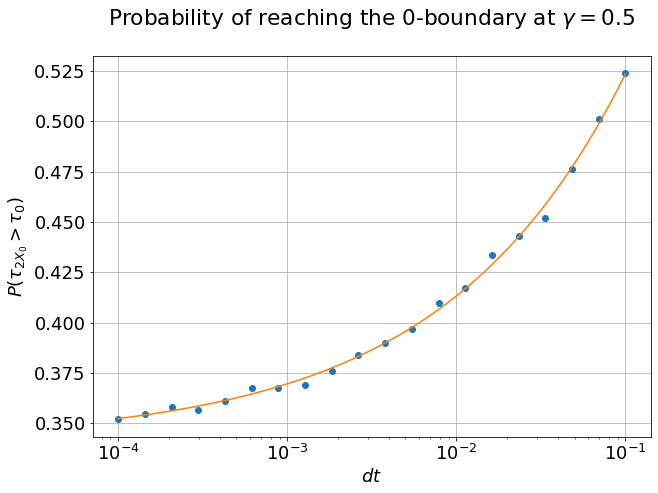

In [0]:
plt.figure(figsize=(10,7))
plt.plot(var2,P[4,:],"o")
plt.plot(np.logspace(-1,-4,100),fit_func(np.linspace(-1,-4,100),popt[0],popt[1],popt[2]))

plt.title("Probability of reaching the 0-boundary at $\gamma = 0.5$\n")

plt.xlabel("$dt$")
plt.ylabel("$P(\\tau_{2X_0}>\\tau_{0})$")
plt.grid()
plt.xscale("log")

In [0]:
popt, pcov = curve_fit(fit_func, np.log10(var2), P[9,:])

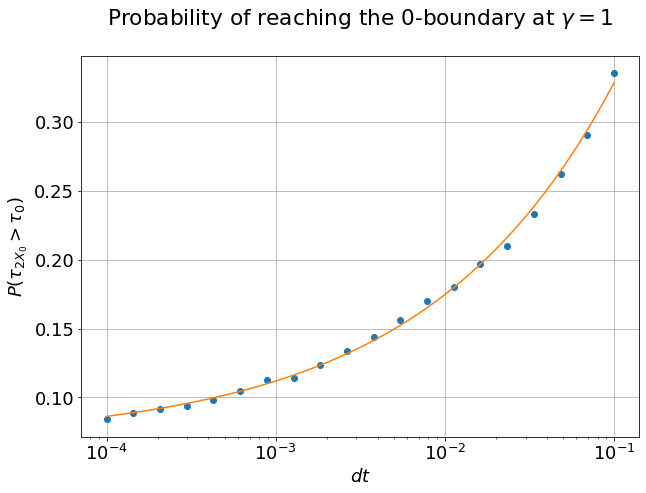

In [0]:
plt.figure(figsize=(10,7))
plt.plot(var2,P[9,:],"o")
plt.plot(np.logspace(-1,-4,100),fit_func(np.linspace(-1,-4,100),popt[0],popt[1],popt[2]))

plt.title("Probability of reaching the 0-boundary at $\gamma = 1$\n")

plt.xlabel("$dt$")
plt.ylabel("$P(\\tau_{2X_0}>\\tau_{0})$")
plt.grid()
plt.xscale("log")

In [0]:
popt, pcov = curve_fit(fit_func, np.log10(var2), P[14,:])

In [0]:
pcov

array([[1.73993408e-04, 2.09089981e-04, 4.82786958e-06],
       [2.09089981e-04, 2.70240982e-04, 7.22163371e-06],
       [4.82786958e-06, 7.22163371e-06, 2.98984965e-07]])

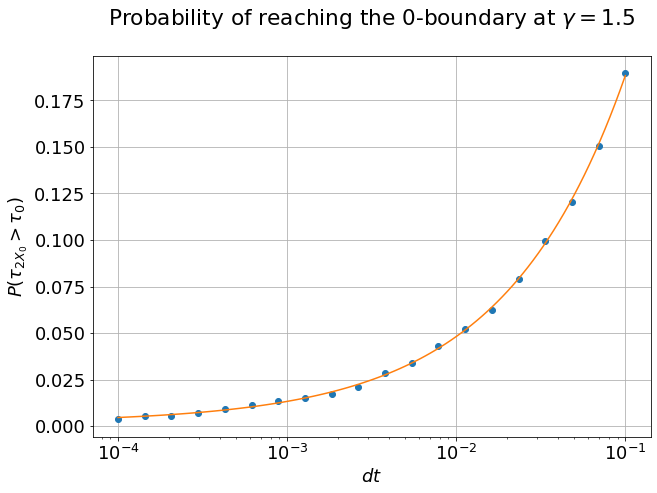

In [0]:
plt.figure(figsize=(10,7))
plt.plot(var2,P[14,:],"o")
plt.plot(np.logspace(-1,-4,100),fit_func(np.linspace(-1,-4,100),popt[0],popt[1],popt[2]))

plt.title("Probability of reaching the 0-boundary at $\gamma = 1.5$\n")

plt.xlabel("$dt$")
plt.ylabel("$P(\\tau_{2X_0}>\\tau_{0})$")
plt.grid()
plt.xscale("log")

### Results

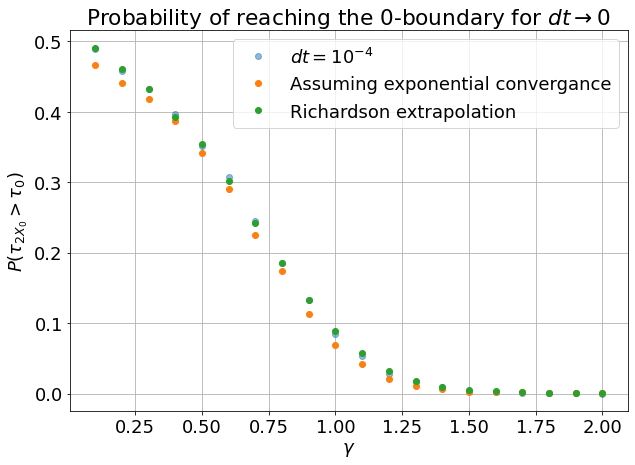

In [0]:
plt.figure(figsize=(10,7))
plt.plot(var,P[:,19],"o",label="$dt=10^{-4}$",alpha = 0.5)
plt.plot(var,P_exp,"o",label = "Assuming exponential convergance")
plt.plot(var,P_lim,"o",label = "Richardson extrapolation")

plt.title("Probability of reaching the 0-boundary for $dt \\rightarrow 0$ ")

plt.xlabel("$\gamma$")
plt.ylabel("$P(\\tau_{2X_0}>\\tau_{0})$")
plt.legend()
plt.grid()

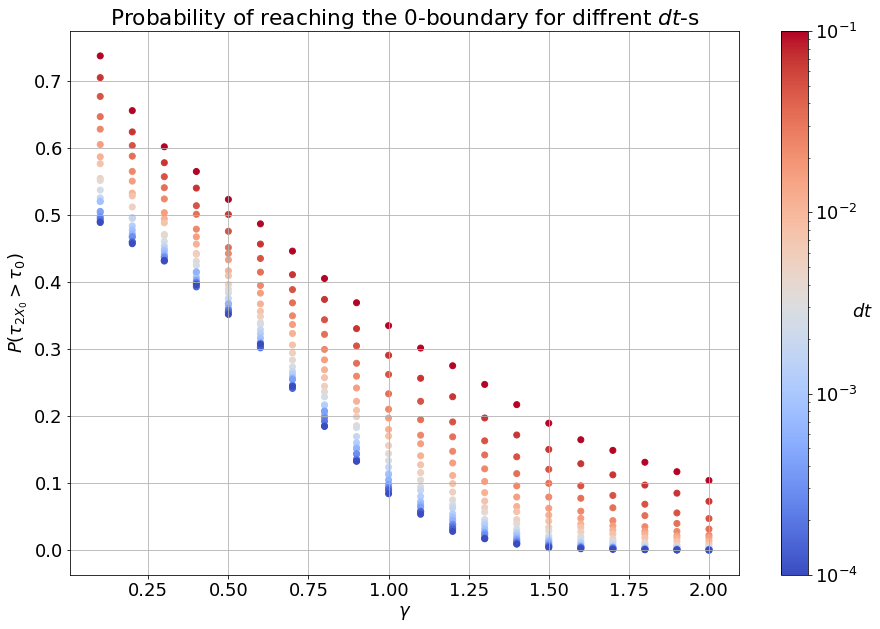

In [0]:
dt = np.zeros((20,20))
for i in range(0,20):
  for j in range(0,20):
    dt[i,j] = var2[i]

plt.figure(figsize=(15,10))
for i in range(20):
  plt.scatter(var,P[:,i],c = dt[i], norm=colors.LogNorm(vmin=dt.min(),vmax=dt.max()), cmap = "coolwarm")

cbar = plt.colorbar()
cbar.set_label("$dt$", rotation = 0)

plt.title("Probability of reaching the 0-boundary for diffrent $dt$-s")
plt.xlabel("$\gamma$")
plt.ylabel("$P(\\tau_{2X_0}>\\tau_{0})$")
plt.grid()

---
---

## Appendix

### A.) Relationship between the CIR-Process and the Noncentral $\chi ^2$-distribution

A noncentral $\chi^2$-distribution can be described with the probability density function:
$$f_\chi (x,k,\lambda) = \sum_{x = 0}^{\infty}{\frac{e^{-\lambda/2}(\lambda/2)^i}{i!}f_{Y_k+2i}(x)}$$
Where $Y_q$ is $\chi^2$ distributed with degrees of freedom of $q$.
The parameters of this thistribution:
* $k$ degrees of freedom
* $\lambda$ noncentrality parameter

According to [2] the CIR process can be simulated by setting the degrees of freedom and non-centrality parameters as follows:
* $k := \frac{4\kappa\theta}{\sigma^2} = 2\gamma$
* $\lambda := X_{t_n}\eta(dt)$
Where we introduced the function $\eta(dt)$ as 
$$ \eta(dt) := \frac{4\kappa}{\sigma^2} e^{-\kappa dt} (1-e^{-\kappa dt})$$

With this the $t_{n+1}$-th step looks like:
$$ X_{t_{n+1}} = \chi^2_k (\lambda) \frac{e^{-\kappa dt}}{\eta(dt)} $$

We can use **numpy.random.noncentral_chisquare** to draw random numbers from the noncentral $\chi^2$-distribution.


References:

[1] https://en.wikipedia.org/wiki/Noncentral_chi-squared_distribution

[2] https://arxiv.org/pdf/0802.4411.pdf

---

### B.) CIR as a squared Ornstein-Uhlenbeck process

Starting from
$$ dX_t = \kappa (\theta -X_t)dt + \sigma \sqrt{X_t}dW_t $$
We can introduce
$$ Y_t(X_t) := \sqrt{X_t} $$
Ito's lemma states that if $X_t$ follows the SDE
$$ dX_t = \mu_t dt + \sigma_t dW_t$$
Then the function $Y_t(X_t)$ has to obey the following SDE:
$$ dY_t = \left( \frac{\partial Y_t}{\partial t} + \mu_t \frac{\partial Y_t}{\partial x} + \frac{\sigma_t^2}{2}\frac{\partial Y_t^2}{\partial^2 x} \right) dt +  \sigma_t \frac{\partial Y_t}{\partial x} dW_t $$

In the case of the CIR-process the derivatives used in Ito's lemma are the following:
$$ \frac{\partial Y_t}{\partial t} = 0 $$
$$ \frac{\partial Y_t}{\partial x} = \frac{1}{2} \frac{1}{\sqrt{X_t}} = \frac{1}{2} \frac{1}{Y_t} $$
$$ \frac{\partial Y_t^2}{\partial^2 x} = -\frac{1}{4} \frac{1}{X_t^{3/2}} = - \frac{1}{4} \frac{1}{Y_t^3}$$
Subsituting these in along with
$$ \mu_t = \kappa (\theta - Y_t^2) $$
$$ \sigma_t = \sigma Y_t $$
We'll arrive to
$$
dY_t = \left[\left(\frac{\kappa\theta}{2}-\frac{\sigma^2}{8}\right)\frac{1}{Y_t} - \frac{\kappa}{2}Y_t\right]dt + \frac{\sigma}{2}dW_t
$$
In the special case of $\frac{\kappa\theta}{2}-\frac{\sigma^2}{8} = 0$, which in terms of $\gamma$  means $\gamma = 0.5$ will result in
$$
dY_t =  - \frac{\kappa}{2}Y_tdt + \frac{\sigma}{2}dW_t
$$
Which is an Ornstein-Uhlenbeck-type SDE.

This has a known solution:
$$
Y_t = Y_0e^{-\frac{\kappa}{2}t} + \frac{\sigma}{2}\int_{0}^{t}{e^{-\frac{\kappa}{2}(t-t')}dW_{t'}}
$$
Furthermore the PDF is also known:
$$
f(Y,t|Y_0,t_0) = \sqrt{\frac{2\kappa}{\pi\sigma^2(1-e^{-\kappa(t-t_0)})}} exp\left[-\frac{2\kappa}{\sigma^2} \frac{(Y-Y_0e^{-\frac{\kappa}{2}(t-t_0)})^2}{1-e^{-{\kappa}(t-t_0)}}\right]
$$
We can transform this back using the known formula
$$
f_X(x) = f_Y(g^{-1}(x))\left|\frac{d}{dx} g^{-1}(x)\right|
$$
With $X = Y^2 \rightarrow g^{-1}(x) = \sqrt{x} \rightarrow \frac{d}{dx} g^{-1}(x)= \frac{1}{2} \frac{1}{\sqrt{x}}$

Substituting it into the transformation rule the PDF for $X_t$ given the initial conditions $X_0$ and $t_0$ will be
$$
f(X,t|X_0,t_0) = \frac{1}{2}\frac{1}{\sqrt{X}} \sqrt{\frac{2\kappa}{\pi\sigma^2(1-e^{-\kappa(t-t_0)})}} exp\left[-\frac{2\kappa}{\sigma^2} \frac{(\sqrt{X}-\sqrt{X_0}e^{-\frac{\kappa}{2}(t-t_0)})^2}{1-e^{-{\kappa}(t-t_0)}}\right]
$$

Which we'll use in the specific case of $X_0 = 0.5$, $t_0 = 0$, $t = 1$, $\kappa = 1$, $\sigma = 2$ (and thus $\gamma = 1/2$).

### C.) Draft

1. Table of Contents
2. Abstract
  
    *Describing the goal of the thesis in a few sentances*

3. Theoretical introduction

  *   Boundary properties
  *   The Cox-Ingersoll-Ross model (based on Hull)
  *   Analytical boundary properties of the CIR model, introducing $\gamma$
  *   The special case of $\gamma = 0.5$ and the Ornstein-Uhlenbeck process
  
    *Showing the analytical propertis of OU, and then transforming them back to CIR to show the PDF for the special case*

4. Thechnical introduction, implementation

  * Random number generation, Mersenne Twister algorithm, Inverse function method
  * Monte-Carlo simulations, Discretization schemes for the CIR process
  * The non-central $\chi^2$ method
  * Convergence acceleration, Richardson extrapolation
  * Multiprocessing

5. Results of the simulations

  * Choosing the right scheme based on the Runtime and KS tests
  * Showing why $P(\tau_{2X_0}>\tau_0)$ is a good order parameter based on measuring the time to cross the barrier
  * Detour: The case of $\gamma = 0.5$ with MC
  * Finding $\gamma_c$ based on the order parameter, comparing different extrapolation tricks

6. Discussion

    *Evaluating the results based on the goals set in the Abstract*

7. Literature

---
---